## Timeseries Clustering Analysis of lDE20 (with lineage Dataframe ready)

- Note that there are fluctuations in the illumination intensity which may be resulting in pathological behavior from the reporter

- This has been normalized out in the upstream processing, but try to fix long term

- Also consider a flat field correction for the final experiment

In [ ]:
import paulssonlab.deaton.trenchripper.trenchripper as tr

import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import sklearn as skl
import dask.dataframe as dd
import dask.array as da
import dask
import warnings
import copy
import random
from sklearn.metrics.pairwise import (
    euclidean_distances,
    manhattan_distances,
    cosine_distances,
)

from sklearn.metrics import silhouette_score
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt
import ast


import pylab
import scipy.cluster.hierarchy as sch

import matplotlib.gridspec as gridspec
import matplotlib as mpl

import holoviews as hv

hv.extension("bokeh")
random.seed(42)
np.random.seed(42)

warnings.filterwarnings(action="once", category=UserWarning)

In [ ]:
def get_sgrnadf_from_scoredf(
    scoredf, feature_labels, time_label="final cell timepoints list"
):
    scoredf_groupby = scoredf.groupby("sgRNA")
    sgrnadf = (
        scoredf_groupby.apply(lambda x: x["phenotype trenchid"].tolist())
        .to_frame()
        .rename(columns={0: "phenotype trenchid"})
    )

    for feature_label in feature_labels:
        sgrnadf[feature_label + ": score"] = scoredf_groupby.apply(
            lambda x: np.array(
                [val for item in x[feature_label + ": score"].tolist() for val in item]
            )
        )

    sgrnadf[time_label] = scoredf_groupby.apply(
        lambda x: np.array([val for item in x[time_label].tolist() for val in item])
    )
    sgrnadf["Gene"] = scoredf_groupby.apply(lambda x: x["Gene"].iloc[0])
    sgrnadf["TargetID"] = scoredf_groupby.apply(lambda x: x["TargetID"].iloc[0])
    sgrnadf["N Mismatch"] = scoredf_groupby.apply(lambda x: x["N Mismatch"].iloc[0])
    sgrnadf["N Observations"] = scoredf_groupby.apply(
        lambda x: len(x["phenotype trenchid"].tolist())
    )
    sgrnadf["Category"] = scoredf_groupby.apply(lambda x: x["Category"].iloc[0])

    return sgrnadf


# No longer using this
# def filter_strong_KOs(df,sampling_thr = 4, n_strongest=2):

#     for i in range(sampling_thr,0,-1):
#         sampling_mask = df["N Observations"]>=sampling_thr
#         mismatch_series = df[sampling_mask]["N Mismatch"]

#         for n in range(n_strongest,0,-1):
#             if len(mismatch_series)>=n:
#                 keep_indices = np.argsort(mismatch_series)[:n]
#                 out_df = df[sampling_mask].iloc[keep_indices]

#                 return out_df


def normalize_timeseries(feature_vector_series, lmbda=0.5):
    timeseries_arr = np.swapaxes(np.array(feature_vector_series.tolist()), 1, 2)
    sigma = np.std(timeseries_arr, axis=1)
    if lmbda > 0.0:
        sigma_prime = ((sigma + 1) ** lmbda - 1) / lmbda  ##yeo-johnson
    elif lmbda == 0.0:
        sigma_prime = np.log(sigma + 1)
    else:
        raise ValueError("lmbda cannot be negative")
    normalizer = sigma / sigma_prime
    normalized_timeseries = timeseries_arr / normalizer[:, np.newaxis, :]
    return normalized_timeseries

### Initial Data Processing

Here, I am going to try and replicate (to some extant) the corrections from "Genomewide phenotypic analysis of growth, cell morphogenesis, and cell cycle events in Escherichia coli"

#### Start Dask

In [ ]:
headpath = (
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/Barcodes"
)

In [ ]:
dask_controller = tr.trcluster.dask_controller(
    walltime="04:00:00",
    local=False,
    n_workers=20,
    memory="16GB",
    working_directory=headpath + "/dask",
)
dask_controller.startdask()

In [ ]:
dask_controller.displaydashboard()

In [ ]:
# dask_controller.shutdown()

#### Import Dataframe

In [ ]:
final_output_df = dd.read_parquet(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/2021-08-10_lDE20_Lineage_Analysis",
    engine="fastparquet",
)
final_output_df = final_output_df.dropna(
    subset=[
        "final timepoints",
        "Mean Exponential Growth Rate: area",
        "Birth: minor_axis_length",
        "Birth: Surface Area",
    ]
)
final_output_df = (
    final_output_df.reset_index().set_index("phenotype trenchid", sorted=True).persist()
)

In [ ]:
final_output_df_trench_groupby = final_output_df.groupby(
    "phenotype trenchid", sort=False
)


#### Filter for "Normal" Sizes at Start

1) Fit a gaussian model to each of the specified feature params during the first t timepoints of the experiment (using a subsample for speed) 
2) Compute a normalized probability trenchwise for these features under the gaussian model, during the first t timepoints of the experiment
3) Eliminate trenches that are under some p percentile value of this probability for each feature
4) Display histograms for each property as well as the resulting theshold

Note that these features should be the only features examined in the resulting analysis. For the notebook, I am looking at:
- Birth length (Lb)
- Division length (Ld)
- Mean Area Increment
- Mean Length Increment
- Mean Width
- Cell cycle duration (Delta t)
- Mean mCherry Intensity

In [ ]:
early_timepoint_cutoff = 30
gaussian_subsample = 0.2
percentile_threshold = 10

filter_params = [
    "Mean Linear Growth Rate: Volume",
    "Mean Exponential Growth Rate: Volume",
    "Birth: Volume",
    "Division: Volume",
    "Mean: minor_axis_length",
    "Mean: mCherry Intensity",
    "Delta t",
]

In [ ]:
early_tpt_df = final_output_df_trench_groupby.apply(
    lambda x: x[x["final timepoints"] < early_timepoint_cutoff].reset_index(drop=True)
).persist()

In [ ]:
for filter_param in filter_params:
    early_param_series = early_tpt_df[filter_param]
    all_param_values = (
        early_param_series.sample(frac=gaussian_subsample).compute().tolist()
    )
    gaussian_fit = sp.stats.norm.fit(all_param_values)
    gaussian_fit = sp.stats.norm(loc=gaussian_fit[0], scale=gaussian_fit[1])

    early_param_series = dd.from_pandas(
        early_param_series.compute().droplevel(1), npartitions=50
    )
    trench_probability = early_param_series.groupby("phenotype trenchid").apply(
        lambda x: np.exp(np.sum(gaussian_fit.logpdf(x)) / len(x)), meta=float
    )

    final_output_df[filter_param + ": Probability"] = trench_probability.persist()

final_output_df_onetrench = (
    final_output_df.groupby("phenotype trenchid").apply(lambda x: x.iloc[0]).compute()
)

plt.figure(figsize=(22, 16))
query_list = []
for i, filter_param in enumerate(filter_params):
    prob_threshold = np.nanpercentile(
        final_output_df_onetrench[filter_param + ": Probability"].tolist(),
        percentile_threshold,
    )
    query = "`" + filter_param + ": Probability` > " + str(prob_threshold)
    query_list.append(query)

    min_v, max_v = (
        np.min(final_output_df_onetrench[filter_param + ": Probability"]),
        np.max(final_output_df_onetrench[filter_param + ": Probability"]),
    )

    plt.subplot(3, 5, i + 1)
    plt.title(filter_param)
    plt.hist(
        final_output_df_onetrench[
            final_output_df_onetrench[filter_param + ": Probability"] < prob_threshold
        ][filter_param + ": Probability"].tolist(),
        bins=50,
        range=(min_v, max_v),
    )
    plt.hist(
        final_output_df_onetrench[
            final_output_df_onetrench[filter_param + ": Probability"] >= prob_threshold
        ][filter_param + ": Probability"].tolist(),
        bins=50,
        range=(min_v, max_v),
    )
plt.show()

compiled_query = " and ".join(query_list)
final_output_df_onetrench_filtered = final_output_df_onetrench.query(compiled_query)
final_output_df_filtered = final_output_df.loc[
    final_output_df_onetrench_filtered.index.tolist()
].persist()

In [ ]:
len(final_output_df_filtered) / len(final_output_df)

In [ ]:
def get_timepoint_values(
    df,
    label,
    min_timepoint,
    max_timepoint,
    time_label="final timepoints",
    flatten_vals=True,
):
    if flatten_vals:
        masked_label_series = df.apply(
            lambda x: np.array(x[label])[
                (np.array(x[time_label]) >= min_timepoint)
                * (np.array(x[time_label]) <= max_timepoint)
            ],
            axis=1,
            meta="object",
        )
        flattened_vals = np.concatenate(masked_label_series.compute().tolist())
        return flattened_vals
    else:
        masked_label_series = (
            df.groupby("phenotype trenchid")
            .apply(
                lambda x: np.array(x[label])[
                    (np.array(x[time_label]) >= min_timepoint)
                    * (np.array(x[time_label]) <= max_timepoint)
                ],
                meta="object",
            )
            .persist()
        )
        return masked_label_series


def get_feature_stats(
    df, feature_label, min_timepoint, max_timepoint, time_label="final timepoints"
):
    feature_vals = get_timepoint_values(
        df, feature_label, min_timepoint, max_timepoint, time_label=time_label
    )
    feature_mean = np.mean(feature_vals)
    feature_std = np.std(feature_vals)
    return feature_mean, feature_std


def get_feature_mean_bytrench(df, feature_label, min_timepoint, max_timepoint):
    masked_label_series = get_timepoint_values(
        df, feature_label, min_timepoint, max_timepoint, flatten_vals=False
    )
    trench_mean_series = (
        masked_label_series.apply(lambda x: np.nanmean(x), meta=float)
        .compute()
        .sort_index()
    )
    return trench_mean_series


def compute_score(df, feature_label, trench_mean_series, feature_mean, feature_std):
    scaling_factor = feature_mean / feature_std
    scores = (df[feature_label] / trench_mean_series) - 1.0
    scores = scaling_factor * scores
    return scores


def get_feature_scores(
    df, feature_label, init_timepoint_range=(0, 20), time_label="final timepoints"
):
    feature_mean, feature_std = get_feature_stats(
        df,
        feature_label,
        init_timepoint_range[0],
        init_timepoint_range[1],
        time_label=time_label,
    )
    trench_mean_series = get_feature_mean_bytrench(
        df, feature_label, init_timepoint_range[0], init_timepoint_range[1]
    )
    scores = compute_score(
        df, feature_label, trench_mean_series, feature_mean, feature_std
    )
    return scores


def get_all_feature_scores(
    df, feature_labels, init_timepoint_range=(0, 20), time_label="final timepoints"
):

    for feature_label in feature_labels:
        print(feature_label)
        feature_scores = get_feature_scores(
            df,
            feature_label,
            init_timepoint_range=init_timepoint_range,
            time_label=time_label,
        )
        df[feature_label + ": z score"] = feature_scores.persist()

    return df

In [ ]:
final_output_df_filtered.loc[:5].compute()

### Normalize Properties

1) Yeo-Johnson transform the data as before (omitting, but return later).
2) Convert transformed values to time-dependent z-scores using the following formula (trying to use means):

$$ z(i,k,t) = \frac{mean_{t\in \tau}(F_{i,t})}{std_{t\in \tau}(F_{i,t})}\Bigg(\frac{F_{i,k,t}}{mean_{t\in \tau}(F_{i,k,t})} - 1\Bigg) $$

where $F_{i,k,t}$ are the feature values for feature i, trench k at time t. $\tau$ are the initial pre-induction timepoints. 

Essentially this is a z-score using the more outlier robust median and interquartile range to define the differences from normal bahavior. The 1.35 factor scales the values such that z-scores represent number of standard deviations from the mean for a normal distribution. Finally the values are normalized by initial behaviors trenchwise by the $median_{t\in \tau}(F_{i,k,t})$ factor.

In [ ]:
params_to_transform = [
    "Birth: Volume",
    "Division: Volume",
    "Mean Linear Growth Rate: Volume",
    "Mean Exponential Growth Rate: Volume",
    "Mean: minor_axis_length",
    "Mean: mCherry Intensity",
    "Delta t",
]

# yeo_subsample = 0.1

# final_output_df_pd_filtered_dask = dd.from_pandas(final_output_df_pd_filtered,npartitions=100).persist()
# dask.distributed.wait(final_output_df_pd_filtered_dask)

# for i,param in enumerate(params_to_transform):
#     all_param_values = [float(val) for item in final_output_df_pd_filtered_dask[param].sample(frac=yeo_subsample).compute().tolist() for val in item]
#     l_norm = sp.stats.yeojohnson_normmax(all_param_values)
#     final_output_df_pd_filtered_dask[param] = final_output_df_pd_filtered_dask[param].apply(lambda x: sp.stats.yeojohnson(np.array(x).astype(float),lmbda = l_norm), meta='object').persist()
# final_output_df_pd_filtered = final_output_df_pd_filtered_dask.compute()

scoredf = get_all_feature_scores(final_output_df_filtered, params_to_transform)
scoredf_noidx = scoredf.reset_index().set_index("Global CellID", drop=True)
sgRNA_dict = {
    sgRNA: i
    for i, sgRNA in enumerate(
        sorted(scoredf_noidx["sgRNA"].unique().compute().tolist())
    )
}
scoredf_noidx["sgRNAid"] = (
    scoredf_noidx["sgRNA"].apply(lambda x: sgRNA_dict[x], meta=int).compute()
)
sgrnadf = scoredf_noidx.reset_index().set_index("sgRNAid", drop=True)
sgrnadf["N Observations"] = sgrnadf.groupby("sgRNAid")["trenchid"].apply(
    lambda x: len(x.unique())
)

### sgRNA Effect Size Filtering (within Gene groups)

1) Threshold sgRNAs to include by number of observations
2) Use Kernel smoothing to smooth out score timeseries into 20 point timeseries
3) For each timepoint, measure the euclidean norm of the feature vector and take the maximum over all time as a measure of effect size
4) Threshold sgRNAs for strong effects by applying a threshold to the euclidean norm that will be displayed with histogram
5) Display a histogram for the sgRNA number per gene

In [ ]:
from statsmodels.nonparametric import kernel_regression
from scipy.stats import iqr
from statsmodels.nonparametric.smoothers_lowess import lowess
import sklearn as skl
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# def get_gridded_obs(df,val_label,grid_step=1):
#     init_t,final_t = df["initial timepoints"],df["final timepoints"]
#     range_series = df.apply(lambda x: list(range(x["initial timepoints"],x["final timepoints"]+1,grid_step)), axis=1)
#     val_series = df.apply(lambda x: [x[val_label] for i in range(x["initial timepoints"],x["final timepoints"]+1,grid_step)], axis=1)

#     range_arr = np.array([val for item in range_series for val in item])
#     val_arr = np.array([val for item in val_series for val in item])

# #     out_arr = np.stack([range_arr,val_arr])

#     range_df = pd.DataFrame(data={"time":range_arr,"value":val_arr})
#     med = range_df.groupby(pd.cut(range_df["time"], np.arange(0, 143, 10))).mean()

# #     med = range_df["value"].rolling(3).median()

#     return med


def timeseries_kernel_reg(df, y_label, min_tpt, max_tpt, kernel_bins, kernel_bandwidth):
    def kernel_reg(
        x_arr,
        y_arr,
        start=min_tpt,
        end=max_tpt,
        kernel_bins=kernel_bins,
        kernel_bandwidth=kernel_bandwidth,
    ):
        intervals = np.linspace(start, end, num=kernel_bins, dtype=float)
        w = kernel_regression.KernelReg(
            y_arr,
            x_arr,
            "c",
            reg_type="lc",
            bw=np.array([kernel_bandwidth]),
            ckertype="gaussian",
        ).fit(intervals)[0]
        reg_x, reg_y = (intervals, w)
        return reg_x, reg_y

    kernel_result = df.groupby("sgRNAid").apply(
        lambda x: kernel_reg(
            (x["final timepoints"].values + x["initial timepoints"].values) / 2,
            x[y_label].values,
        )[1],
        meta=float,
    )

    return kernel_result


def get_all_kernel_regs(
    df, y_label_list, min_tpt, max_tpt, kernel_bins=20, kernel_bandwidth=10
):
    out_df = copy.copy(df)

    for y_label in y_label_list:
        kernel_result = timeseries_kernel_reg(
            out_df, y_label, min_tpt, max_tpt, kernel_bins, kernel_bandwidth
        )
        out_df["Kernel Trace: " + y_label] = kernel_result.persist()

    return out_df

In [ ]:
N_Observations_thr = 4

sgrnadf_wellsampled = sgrnadf[sgrnadf["N Observations"] >= N_Observations_thr].persist()

In [ ]:
# making an observation grid to project vals onto

min_tpt = 0
max_tpt = 143

kernel_bins = 20
kernel_bandwidth = 10

score_params = [param + ": z score" for param in params_to_transform]

trace_df = get_all_kernel_regs(
    sgrnadf_wellsampled,
    score_params,
    min_tpt,
    max_tpt,
    kernel_bins=kernel_bins,
    kernel_bandwidth=kernel_bandwidth,
)
trace_df = trace_df.groupby("sgRNAid").apply(lambda x: x.iloc[0]).compute()

In [ ]:
kernel_params = [
    "Kernel Trace: " + param + ": z score" for param in params_to_transform
]
feature_vector_series = trace_df.apply(
    lambda x: np.array(x[kernel_params].tolist()), axis=1
)
trace_df["Feature Vector"] = feature_vector_series
trace_df_nan_filtered = trace_df[
    ~trace_df["Feature Vector"].apply(lambda x: np.any(np.isnan(x)))
]

In [ ]:
strong_effect_threshold = 35

zero_vector = np.zeros((1, trace_df_nan_filtered["Feature Vector"].iloc[0].shape[0]))
feature_arr = np.array(trace_df_nan_filtered["Feature Vector"].tolist())
flattened_feature_arr = np.swapaxes(feature_arr, 1, 2).reshape(-1, feature_arr.shape[1])
dist_arr = euclidean_distances(flattened_feature_arr, zero_vector).reshape(
    feature_arr.shape[0], feature_arr.shape[2]
)
trace_df_nan_filtered["Integrated Euclidean Norm"] = sp.integrate.simpson(dist_arr)
# lowess_trace_df["Max Euclidean Norm"] = np.max(dist_arr,axis=1)

sgrnadf_strong_effect = trace_df_nan_filtered[
    trace_df_nan_filtered["Integrated Euclidean Norm"] >= strong_effect_threshold
]
min_v, max_v = (
    np.min(trace_df_nan_filtered["Integrated Euclidean Norm"]),
    np.percentile(trace_df_nan_filtered["Integrated Euclidean Norm"], 99),
)

plt.figure(figsize=(8, 8))
plt.title("Integrated Euclidean Norm")
plt.hist(
    trace_df_nan_filtered[
        trace_df_nan_filtered["Integrated Euclidean Norm"] < strong_effect_threshold
    ]["Integrated Euclidean Norm"].tolist(),
    bins=50,
    range=(min_v, max_v),
)
plt.hist(
    trace_df_nan_filtered[
        trace_df_nan_filtered["Integrated Euclidean Norm"] >= strong_effect_threshold
    ]["Integrated Euclidean Norm"].tolist(),
    bins=50,
    range=(min_v, max_v),
)
plt.show()

unique_genes, gene_counts = np.unique(sgrnadf_strong_effect["Gene"], return_counts=True)
plt.title("sgRNAs per Gene")
plt.xticks(range(0, 20, 2), labels=range(0, 20, 2))
plt.hist(gene_counts, bins=np.arange(20) - 0.5)
plt.show()

### Pick Representative Effect per TargetID
Note this may need to be revisited later to resolve transients that are only resolvable at intermediate KO

1) For each target, pick the sgRNA that has the strongest phenotype (highest integrated euclidean norm)
2) Additionally identify any targets with titration information by saving a dataframe with targetIDs that posess at least N sgRNAs
    - this is in a preliminary form; transfer to a full notebook later

In [ ]:
sgrnadf_strong_effect.to_pickle(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/2021-08-16_gene_cluster_df_full.pkl"
)

In [ ]:
most_rep_example_series = (
    sgrnadf_strong_effect.reset_index(drop=False)
    .groupby("TargetID")
    .apply(lambda x: x.iloc[np.argmax(x["Integrated Euclidean Norm"])])
    .reset_index(drop=True)
    .set_index("sgRNA", drop=True)
)

## THIS IS FOR A LOG TRANSFORMATION, try to do this earlier when it makes more sense....
# normalized_timeseries = np.swapaxes(normalize_timeseries(most_rep_example_series["Feature Vector"], lmbda=0.5),1,2)
# most_rep_example_series["Normalized Feature Vector"] = [normalized_timeseries[i] for i in range(normalized_timeseries.shape[0])]

### Effect Distance Metrics

Now, I want to evaluate the performance of different distance metrics on the data wrt seperating it maximally while also preserving similarity within replicates

- DTW (can be done with cosine similarity) 
- cosine similarity (same as pearson for z-scores)
- cross correlation

Seems like soft-DTW is a pretty good option. Going forward with that for now.

<!-- In the end cosine similarity was chosen as it produced superior silhouette scores for sets of targets from genes with different phenotypes. -->

In [ ]:
sgrnadf_examples_for_distance_metric = most_rep_example_series[
    most_rep_example_series["Gene"].isin(["ftsN", "rplA", "mreB", "tufB", "tff"])
]

In [ ]:
from tslearn.metrics import (
    dtw,
    cdist_dtw,
    dtw_path_from_metric,
    cdist_soft_dtw,
    cdist_soft_dtw_normalized,
)
import tslearn
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
timeseries_arr = np.swapaxes(
    np.array(sgrnadf_examples_for_distance_metric["Feature Vector"].tolist()), 1, 2
)

In [ ]:
for gamma in [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]:

    print(
        "Soft-DTW Gamma="
        + str(gamma)
        + ": "
        + str(
            tslearn.clustering.silhouette_score(
                timeseries_arr,
                sgrnadf_examples_for_distance_metric["Gene"].tolist(),
                metric="softdtw",
                gamma=gamma,
            )
        )
    )

dist_mat = np.zeros((timeseries_arr.shape[0], timeseries_arr.shape[0]))
for i in range(timeseries_arr.shape[0]):
    for j in range(i + 1, timeseries_arr.shape[0]):
        dist = dtw_path_from_metric(
            timeseries_arr[i],
            timeseries_arr[j],
            metric="cosine",
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=3,
        )[1]
        dist_mat[i, j] = dist
        dist_mat[j, i] = dist
print(
    "Cosine-DTW: "
    + str(
        tslearn.clustering.silhouette_score(
            dist_mat,
            sgrnadf_examples_for_distance_metric["Gene"].tolist(),
            metric="precomputed",
        )
    )
)

dist_mat = np.zeros((timeseries_arr.shape[0], timeseries_arr.shape[0]))
for i in range(timeseries_arr.shape[0]):
    for j in range(i + 1, timeseries_arr.shape[0]):
        dist = dtw_path_from_metric(
            timeseries_arr[i],
            timeseries_arr[j],
            metric="euclidean",
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=3,
        )[1]
        dist_mat[i, j] = dist
        dist_mat[j, i] = dist
print(
    "Euclidean-DTW: "
    + str(
        tslearn.clustering.silhouette_score(
            dist_mat,
            sgrnadf_examples_for_distance_metric["Gene"].tolist(),
            metric="precomputed",
        )
    )
)

In [ ]:
soft_dtw_dist_arr = tslearn.metrics.cdist_soft_dtw(timeseries_arr)

In [ ]:
plt.hist(soft_dtw_dist_arr.flatten(), bins=100)
plt.show()

### Detecting different effects against single genes

1) Plot a histogram of minimum soft-DTW similarity within groups of TargetIDs against the same genes (for genes with more than one targetID)
2) Use affinity propagation to select the number of phenotype clusters to use per gene (preference still needs to be dialed in, not sure how to optimize on this)
3) Among each cluster, represent the final effect as the strongest effect (integrated euc norm) of the members of the cluster

~~3) Among each cluster, represent the final effect as the median of the members of the cluster~~


In [ ]:
def get_normed_softdtw(feature_vector_series):
    dist_mat = cdist_soft_dtw_normalized(
        np.swapaxes(np.array(feature_vector_series.tolist()), 1, 2)
    )
    timeseries_len = (
        feature_vector_series[0].shape[0] * feature_vector_series[0].shape[1]
    )
    dist_mat = dist_mat / timeseries_len
    return dist_mat


def get_upper_right_vals(a):
    upper_tri = np.triu(a, k=1)
    upper_tri[upper_tri == 0.0] = np.NaN
    return upper_tri


def get_sgRNA_clusters(df, preference=0.6):
    gene_indexed_df = (
        df.reset_index(drop=False)
        .set_index("Gene")[["sgRNA", "Feature Vector", "TargetID"]]
        .sort_index()
    )
    gene_indexed_df["sgRNA Cluster"] = pd.Series(
        np.zeros(len(gene_indexed_df), dtype=int), dtype=int
    )
    gene_df_list = []
    for gene in gene_indexed_df.index.tolist():
        gene_df = gene_indexed_df.loc[[gene]]
        if len(gene_df) > 1:
            gene_feature_vector = gene_df["Feature Vector"]
            soft_dtw_dist = get_normed_softdtw(gene_feature_vector)
            af_labels = (
                AffinityPropagation(
                    affinity="precomputed", preference=preference, random_state=42
                )
                .fit_predict(-soft_dtw_dist)
                .astype(int)
            )
            gene_indexed_df.loc[gene, "sgRNA Cluster"] = af_labels
        else:
            gene_indexed_df.loc[gene, "sgRNA Cluster"] = 0
    gene_indexed_df["sgRNA Cluster"] = gene_indexed_df["sgRNA Cluster"].astype(int)
    return gene_indexed_df

In [ ]:
n_sgrna_replicate_thr = 2
pref_factor = 3.0

gene_list, counts_list = np.unique(most_rep_example_series["Gene"], return_counts=True)
genes_with_many_replicate_sgRNAs = gene_list[counts_list >= n_sgrna_replicate_thr]
sgrnadf_many_copies_per_gene = most_rep_example_series[
    most_rep_example_series["Gene"].isin(genes_with_many_replicate_sgRNAs)
]

max_distance_within_gene = sgrnadf_many_copies_per_gene.groupby("Gene").apply(
    lambda x: np.nanmax(get_upper_right_vals(get_normed_softdtw(x["Feature Vector"])))
)
plt.title("Maximum soft-DTW Distance per Gene")
plt.hist(max_distance_within_gene, bins=50)
plt.show()

dist_within_gene = sgrnadf_many_copies_per_gene.groupby("Gene").apply(
    lambda x: get_upper_right_vals(get_normed_softdtw(x["Feature Vector"])).flatten()
)
dist_within_gene = [val for item in dist_within_gene.tolist() for val in item]
median_similarity = -np.nanmedian(dist_within_gene)

gene_df = get_sgRNA_clusters(
    most_rep_example_series, preference=pref_factor * median_similarity
)

most_rep_example_series["sgRNA Cluster"] = gene_df.set_index("sgRNA")["sgRNA Cluster"]
most_rep_example_series["sgRNA Cluster Label"] = most_rep_example_series.apply(
    lambda x: str(x["Gene"]) + "-" + str(x["sgRNA Cluster"]), axis=1
)

gene_cluster_df = most_rep_example_series[
    ["sgRNA Cluster Label", "Feature Vector", "Gene", "Integrated Euclidean Norm"]
    + kernel_params
].reset_index(drop=True)
gene_cluster_groupby = gene_cluster_df.groupby("sgRNA Cluster Label")
# median_feature_series = gene_cluster_groupby.apply(lambda x: np.median(np.stack(x["Feature Vector"]).astype(float), axis=0)).to_frame().rename(columns={0:"Feature Vector"})
feature_series = (
    gene_cluster_groupby.apply(
        lambda x: x.iloc[np.argmax(x["Integrated Euclidean Norm"])]["Feature Vector"]
    )
    .to_frame()
    .rename(columns={0: "Feature Vector"})
)

gene_cluster_df = gene_cluster_groupby.apply(
    lambda x: x.iloc[0][["Gene"] + kernel_params]
)
gene_cluster_df = gene_cluster_df.join(feature_series)

In [ ]:
gene_cluster_df.to_pickle(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/2021-08-16_gene_cluster_df.pkl"
)

## Titration

In [ ]:
import scanpy as sc
import anndata
import scipy as sp
import scipy.sparse
import dask.array as da
from igraph.drawing.text import TextDrawer
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.metrics import cdist_soft_dtw_normalized, cdist_soft_dtw
import networkx as nx
import igraph as ig
import leidenalg
import umap

In [ ]:
def get_sgrnadf_from_scoredf(
    scoredf, feature_labels, time_label="final cell timepoints list"
):
    scoredf_groupby = scoredf.groupby("sgRNA")
    sgrnadf = (
        scoredf_groupby.apply(lambda x: x["phenotype trenchid"].tolist())
        .to_frame()
        .rename(columns={0: "phenotype trenchid"})
    )

    for feature_label in feature_labels:
        sgrnadf[feature_label + ": score"] = scoredf_groupby.apply(
            lambda x: np.array(
                [val for item in x[feature_label + ": score"].tolist() for val in item]
            )
        )

    sgrnadf[time_label] = scoredf_groupby.apply(
        lambda x: np.array([val for item in x[time_label].tolist() for val in item])
    )
    sgrnadf["Gene"] = scoredf_groupby.apply(lambda x: x["Gene"].iloc[0])
    sgrnadf["TargetID"] = scoredf_groupby.apply(lambda x: x["TargetID"].iloc[0])
    sgrnadf["N Mismatch"] = scoredf_groupby.apply(lambda x: x["N Mismatch"].iloc[0])
    sgrnadf["N Observations"] = scoredf_groupby.apply(
        lambda x: len(x["phenotype trenchid"].tolist())
    )
    sgrnadf["Category"] = scoredf_groupby.apply(lambda x: x["Category"].iloc[0])

    return sgrnadf


# No longer using this
# def filter_strong_KOs(df,sampling_thr = 4, n_strongest=2):

#     for i in range(sampling_thr,0,-1):
#         sampling_mask = df["N Observations"]>=sampling_thr
#         mismatch_series = df[sampling_mask]["N Mismatch"]

#         for n in range(n_strongest,0,-1):
#             if len(mismatch_series)>=n:
#                 keep_indices = np.argsort(mismatch_series)[:n]
#                 out_df = df[sampling_mask].iloc[keep_indices]

#                 return out_df


def normalize_timeseries(feature_vector_series, lmbda=0.5):
    timeseries_arr = np.swapaxes(np.array(feature_vector_series.tolist()), 1, 2)
    sigma = np.std(timeseries_arr, axis=1)
    if lmbda > 0.0:
        sigma_prime = ((sigma + 1) ** lmbda - 1) / lmbda  ##yeo-johnson
    elif lmbda == 0.0:
        sigma_prime = np.log(sigma + 1)
    else:
        raise ValueError("lmbda cannot be negative")
    normalizer = sigma / sigma_prime
    normalized_timeseries = timeseries_arr / normalizer[:, np.newaxis, :]
    return normalized_timeseries

In [ ]:
gene_cluster_df = pd.read_pickle(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/2021-08-16_gene_cluster_df.pkl"
)
gene_cluster_df_full = pd.read_pickle(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/2021-08-16_gene_cluster_df_full.pkl"
)

In [ ]:
zscore_traces = [
    "Kernel Trace: Birth: Volume: z score",
    "Kernel Trace: Division: Volume: z score",
    "Kernel Trace: Mean Linear Growth Rate: Volume: z score",
    "Kernel Trace: Mean Exponential Growth Rate: Volume: z score",
    "Kernel Trace: Mean: minor_axis_length: z score",
    "Kernel Trace: Mean: mCherry Intensity: z score",
    "Kernel Trace: Delta t: z score",
]

for zscore_trace in zscore_traces:
    avg_zscore = gene_cluster_df_full.apply(lambda x: np.mean(x[zscore_trace]), axis=1)
    gene_cluster_df_full[zscore_trace + ": Mean"] = avg_zscore

for zscore_trace in zscore_traces:
    max_zscore = gene_cluster_df_full.apply(lambda x: np.max(x[zscore_trace]), axis=1)
    gene_cluster_df_full[zscore_trace + ": Max"] = max_zscore

In [ ]:
gene_cluster_df_full["N Match"] = 20 - gene_cluster_df_full["N Mismatch"]

In [ ]:
min_titration = 4

target_count_series = gene_cluster_df_full.groupby("TargetID").apply(lambda x: len(x))
targetid_above_thr = target_count_series[
    target_count_series >= min_titration
].index.tolist()
titration_df = gene_cluster_df_full[
    gene_cluster_df_full["TargetID"].isin(targetid_above_thr)
]

#### Pearson R

In [ ]:
def get_pearson_df(titration_df, variable_name, pearson_p_val=0.05):

    var_df = (
        titration_df.groupby("TargetID")
        .apply(lambda x: x[variable_name].tolist())
        .to_frame()
    )
    var_df = var_df.rename(columns={0: variable_name})
    var_df["N Match"] = titration_df.groupby("TargetID").apply(
        lambda x: x["N Match"].tolist()
    )
    var_df[variable_name + ": Pearson R"] = var_df.apply(
        lambda x: sp.stats.pearsonr(x["N Match"], x[variable_name])[0], axis=1
    )
    var_df[variable_name + ": Pearson P-val"] = var_df.apply(
        lambda x: sp.stats.pearsonr(x["N Match"], x[variable_name])[1], axis=1
    )

    return var_df

In [ ]:
var_list = [
    "Kernel Trace: Birth: Volume: z score: Mean",
    "Kernel Trace: Division: Volume: z score: Mean",
    "Kernel Trace: Mean Linear Growth Rate: Volume: z score: Mean",
    "Kernel Trace: Mean Exponential Growth Rate: Volume: z score: Mean",
    "Kernel Trace: Mean: minor_axis_length: z score: Mean",
    "Kernel Trace: Mean: mCherry Intensity: z score: Mean",
    "Kernel Trace: Delta t: z score: Mean",
]

pearson_df = titration_df.groupby("TargetID").apply(lambda x: x.iloc[0])

for var_label in var_list:
    var_df = get_pearson_df(titration_df, var_label)
    pearson_df[var_label + ": Pearson R"] = var_df[var_label + ": Pearson R"]
    pearson_df[var_label + ": Pearson P-val"] = var_df[var_label + ": Pearson P-val"]

In [ ]:
pearson_df

In [ ]:
p_val_thr = 0.05

pearson_p_labels = [var_label + ": Pearson P-val" for var_label in var_list]
pearson_r_labels = [var_label + ": Pearson R" for var_label in var_list]

pearson_r_sig = np.any(pearson_df[pearson_p_labels] < p_val_thr, axis=1)
pearson_r_sig_df = pearson_df[pearson_r_sig]

In [ ]:
n_targetids = len(gene_cluster_df_full["TargetID"].unique().tolist())
n_titration_targetids = np.sum(pearson_r_sig)

In [ ]:
print(n_titration_targetids / n_targetids)

In [ ]:
pos_arr = (pearson_r_sig_df[pearson_r_labels] > 0.0).values
neg_arr = (pearson_r_sig_df[pearson_r_labels] <= 0.0).values
sig_arr = (pearson_r_sig_df[pearson_p_labels] < p_val_thr).values

sig_pos_arr = sig_arr * pos_arr
sig_neg_arr = sig_arr * neg_arr

merged_arr = np.zeros(sig_arr.shape, dtype=int)
merged_arr[sig_pos_arr] = 1
merged_arr[sig_neg_arr] = -1

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(merged_arr.T)

Should do this after clusters added to df so sorting is easier

#### Spearman R

In [ ]:
def get_spearman_df(titration_df, variable_name, pearson_p_val=0.05):

    var_df = (
        titration_df.groupby("TargetID")
        .apply(lambda x: x[variable_name].tolist())
        .to_frame()
    )
    var_df = var_df.rename(columns={0: variable_name})
    var_df["N Match"] = titration_df.groupby("TargetID").apply(
        lambda x: x["N Match"].tolist()
    )
    var_df[variable_name + ": Spearman R"] = var_df.apply(
        lambda x: sp.stats.spearmanr(x["N Match"], x[variable_name])[0], axis=1
    )
    var_df[variable_name + ": Spearman P-val"] = var_df.apply(
        lambda x: sp.stats.spearmanr(x["N Match"], x[variable_name])[1], axis=1
    )

    return var_df

In [ ]:
var_list = [
    "Kernel Trace: Birth: Volume: z score: Mean",
    "Kernel Trace: Division: Volume: z score: Mean",
    "Kernel Trace: Mean Linear Growth Rate: Volume: z score: Mean",
    "Kernel Trace: Mean Exponential Growth Rate: Volume: z score: Mean",
    "Kernel Trace: Mean: minor_axis_length: z score: Mean",
    "Kernel Trace: Mean: mCherry Intensity: z score: Mean",
    "Kernel Trace: Delta t: z score: Mean",
]

spearman_df = titration_df.groupby("TargetID").apply(lambda x: x.iloc[0])

for var_label in var_list:
    var_df = get_spearman_df(titration_df, var_label)
    spearman_df[var_label + ": Spearman R"] = var_df[var_label + ": Spearman R"]
    spearman_df[var_label + ": Spearman P-val"] = var_df[var_label + ": Spearman P-val"]

In [ ]:
spearman_p_val_thr = 0.05

spearman_p_labels = [var_label + ": Spearman P-val" for var_label in var_list]
spearman_r_labels = [var_label + ": Spearman R" for var_label in var_list]

spearman_r_sig = np.any(spearman_df[spearman_p_labels] < spearman_p_val_thr, axis=1)
spearman_r_sig_df = spearman_df[spearman_r_sig]

In [ ]:
n_targetids = len(gene_cluster_df_full["TargetID"].unique().tolist())
n_titration_targetids = np.sum(spearman_r_sig)

In [ ]:
print(n_titration_targetids / n_targetids)

In [ ]:
pos_arr = (spearman_r_sig_df[spearman_r_labels] > 0.0).values
neg_arr = (spearman_r_sig_df[spearman_r_labels] <= 0.0).values
sig_arr = (spearman_r_sig_df[spearman_p_labels] < p_val_thr).values

sig_pos_arr = sig_arr * pos_arr
sig_neg_arr = sig_arr * neg_arr

merged_arr = np.zeros(sig_arr.shape, dtype=int)
merged_arr[sig_pos_arr] = 1
merged_arr[sig_neg_arr] = -1

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(merged_arr.T)

## PAGA

In [ ]:
import scanpy as sc
import anndata
import scipy as sp
import scipy.sparse

In [ ]:
import dask.array as da
from igraph.drawing.text import TextDrawer
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.metrics import cdist_soft_dtw_normalized, cdist_soft_dtw
import networkx as nx
import igraph as ig
import leidenalg
import umap


def knn_leiden_dist(dist_arr, n_neighbors=5, n_iterations=2):

    knn = skl.neighbors.NearestNeighbors(
        n_neighbors=n_neighbors + 1, metric="precomputed", algorithm="brute"
    ).fit(
        dist_arr
    )  # plus one neighbor to account for self-loops

    G = knn.kneighbors_graph(dist_arr, mode="distance")
    G[G.nonzero()] = 1.0 / (G[G.nonzero()] + 1.0)  ##Distance normalization
    G_arr = G.toarray()

    ig_G = ig.Graph.Weighted_Adjacency(G_arr, mode="undirected", loops=False)
    ig_G.vs["index"] = [i for i in range(ig_G.vcount())]
    ig_G.vs["weight"] = [1.0 for i in range(ig_G.vcount())]

    part = leidenalg.find_partition(
        ig_G,
        leidenalg.ModularityVertexPartition,
        n_iterations=n_iterations,
        weights="weight",
    )

    return G, ig_G, part


def knn_leiden_softdtw(X, n_neighbors=5, n_iterations=2):

    norm_soft_dtw_Y = cdist_soft_dtw_normalized(X)  ##This is a distance

    G, ig_G, part = knn_leiden_dist(
        norm_soft_dtw_Y, n_neighbors=n_neighbors, n_iterations=n_iterations
    )


def parallel_norm_soft_dtw(X, chunk_size=100):
    X_dask = da.from_array(X, chunks=(chunk_size, X.shape[1], X.shape[2]))
    soft_dtw_arr = da.blockwise(
        cdist_soft_dtw, "ik", X_dask, "itd", X_dask, "ktd", concatenate=True
    ).compute()
    d_ii = np.diag(soft_dtw_arr)
    norm_soft_dtw_arr = soft_dtw_arr - (
        0.5 * (d_ii.reshape((-1, 1)) + d_ii.reshape((1, -1)))
    )
    return norm_soft_dtw_arr

In [ ]:
gene_cluster_df = pd.read_pickle(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/2021-08-16_gene_cluster_df.pkl"
)
gene_cluster_df_full = pd.read_pickle(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/2021-08-16_gene_cluster_df_full.pkl"
)

In [ ]:
zscore_traces = [
    "Kernel Trace: Birth: Volume: z score",
    "Kernel Trace: Division: Volume: z score",
    "Kernel Trace: Mean Linear Growth Rate: Volume: z score",
    "Kernel Trace: Mean Exponential Growth Rate: Volume: z score",
    "Kernel Trace: Mean: minor_axis_length: z score",
    "Kernel Trace: Mean: mCherry Intensity: z score",
    "Kernel Trace: Delta t: z score",
]

for zscore_trace in zscore_traces:
    avg_zscore = gene_cluster_df_full.apply(lambda x: np.mean(x[zscore_trace]), axis=1)
    gene_cluster_df_full[zscore_trace + ": Mean"] = avg_zscore

for zscore_trace in zscore_traces:
    max_zscore = gene_cluster_df_full.apply(lambda x: np.max(x[zscore_trace]), axis=1)
    gene_cluster_df_full[zscore_trace + ": Max"] = max_zscore

In [ ]:
X = np.array(gene_cluster_df_full["Feature Vector"].tolist())
X = np.swapaxes(X, 1, 2)

In [ ]:
norm_soft_dtw_arr = parallel_norm_soft_dtw(X)

In [ ]:
an_df = anndata.AnnData(
    X=X.reshape(X.shape[0], -1), obs=gene_cluster_df_full
)  # AnnData container to use scanpy functions with unwrapped time vector

In [ ]:
n_neighbors = 10
n_pcs = 20  # This shouldn't affect anything

sc.pp.neighbors(an_df, n_neighbors=n_neighbors, n_pcs=n_pcs)
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(
    norm_soft_dtw_arr, n_neighbors=n_neighbors, metric="precomputed"
)
(
    an_df.uns["neighbors"]["distances"],
    an_df.uns["neighbors"]["connectivities"],
) = sc.neighbors._compute_connectivities_umap(
    knn_indices,
    knn_dists,
    an_df.shape[0],
    n_neighbors,  # change to neighbors you plan to use
)
an_df.obsp["distances"] = an_df.uns["neighbors"]["distances"]
an_df.obsp["connectivities"] = an_df.uns["neighbors"]["connectivities"]

In [ ]:
paga_df = copy.deepcopy(an_df)
sc.tl.leiden(paga_df, resolution=1.0, n_iterations=-1)

In [ ]:
sc.tl.paga(paga_df, groups="leiden")

In [ ]:
sc.pl.paga(paga_df, add_pos=True)

In [ ]:
sc.tl.umap(paga_df, init_pos="paga")

In [ ]:
sc.pl.umap(paga_df, color="leiden", legend_loc="on data")

In [ ]:
paga_df.uns["iroot"] = np.argmin(
    gene_cluster_df_full["Integrated Euclidean Norm"].values
)  # HACK
sc.tl.dpt(paga_df)

In [ ]:
sc.pl.umap(
    paga_df,
    color=[
        "leiden",
        "dpt_pseudotime",
        "Kernel Trace: Mean: mCherry Intensity: z score: Mean",
        "Kernel Trace: Birth: Volume: z score: Mean",
    ],
    legend_loc="on data",
)

### Making a Directed Graph with Paths

In [ ]:
paga_dict = paga_df.uns["paga"]
adj_mat = paga_dict["connectivities"]
neg_log_adj_mat = copy.deepcopy(adj_mat)
neg_log_adj_mat[neg_log_adj_mat.nonzero()] = -np.log(
    neg_log_adj_mat[neg_log_adj_mat.nonzero()]
)

paga_G = nx.convert_matrix.from_numpy_matrix(adj_mat)
neg_log_paga_G = nx.convert_matrix.from_numpy_matrix(neg_log_adj_mat)

paga_G_shortest_path_dict = nx.algorithms.shortest_path(neg_log_paga_G, weight="weight")

In [ ]:
def interpolate_steps(step_list, shortest_path_dict=paga_G_shortest_path_dict):
    pair_step_list = [step_list[i : i + 2] for i in range(len(step_list) - 1)]
    interp_step_list = [shortest_path_dict[step[0]][step[1]] for step in pair_step_list]
    interp_step_list = [item for item in interp_step_list if len(item) > 1]
    return interp_step_list


def get_titration_transitions(
    an_df,
    shortest_path_dict,
    root_node=0,
    path_length_thr=5,
    min_transitions_thr=3,
    interpolate=True,
):
    titration_groupby = an_df.obs.groupby("TargetID")
    titration_df = titration_groupby.apply(
        lambda x: [root_node]
        + np.array(x["leiden"])
        .astype(int)[np.argsort(x["N Mismatch"].values)[::-1]]
        .tolist()
    )
    titration_df = titration_df[titration_df.apply(lambda x: len(x)) >= path_length_thr]

    if interpolate:
        paga_dict = an_df.uns["paga"]
        adj_mat = paga_dict["connectivities"]
        neg_log_adj_mat = copy.deepcopy(adj_mat)
        neg_log_adj_mat[neg_log_adj_mat.nonzero()] = -np.log(
            neg_log_adj_mat[neg_log_adj_mat.nonzero()]
        )
        neg_log_paga_G = nx.convert_matrix.from_numpy_matrix(neg_log_adj_mat)
        shortest_path_dict = nx.algorithms.shortest_path(
            neg_log_paga_G, weight="weight"
        )
        all_titration_paths = [
            item
            for item in titration_df.apply(
                lambda x: interpolate_steps(x, shortest_path_dict=shortest_path_dict)
            ).tolist()
            if len(item) > 0
        ]
        all_titration_paths = [val for item in all_titration_paths for val in item]

    else:

        all_titration_paths = titration_df.tolist()

    all_titration_path_steps = [
        tuple(item[i : i + 2])
        for item in all_titration_paths
        for i in range(len(item) - 1)
    ]

    T_titrations = np.zeros(an_df.uns["paga"]["connectivities"].shape)
    transitions, counts = np.unique(
        all_titration_path_steps, axis=0, return_counts=True
    )
    for i, transition in enumerate(transitions):
        T_titrations[transition[0], transition[1]] = counts[i]

    np.fill_diagonal(T_titrations, 0)
    T_titrations[T_titrations < min_transitions_thr] = 0
    norm_factor = np.sum(T_titrations, axis=1)
    #     T_titrations[norm_factor==0.] = 1./(norm_factor.shape[0])
    norm_factor[norm_factor == 0.0] = 1.0
    T_titrations = T_titrations / norm_factor[:, np.newaxis]
    T_titrations = sp.sparse.csr_matrix(T_titrations)

    return T_titrations

In [ ]:
T_titrations = get_titration_transitions(
    paga_df,
    paga_G_shortest_path_dict,
    root_node=0,
    path_length_thr=3,
    min_transitions_thr=5,
    interpolate=False,
)
plt.imshow(T_titrations.toarray())
plt.show()

# T_titrations = get_titration_transitions(paga_df, root_node = 0, path_length_thr = 5, min_transitions_thr = 3, interpolate = False)
# plt.imshow(T_titrations)
# plt.show()

In [ ]:
T_DAG_thr

In [ ]:
DAG_thr = 0.2

T_DAG = T_titrations - T_titrations.T
plt.imshow(T_DAG.toarray())
plt.show()

plt.imshow(T_DAG.toarray() > DAG_thr)
plt.show()

T_DAG_thr = copy.deepcopy(T_titrations)
T_DAG_thr[T_DAG.toarray() < DAG_thr] = 0
norm = np.sum(T_DAG_thr, axis=1)
norm[norm == 0] = 1.0
T_DAG_thr = T_DAG_thr / norm
T_DAG_thr = sp.sparse.csr_matrix(T_DAG_thr)

plt.imshow(T_DAG_thr.toarray())
plt.show()

In [ ]:
paga_df.uns["paga"]["Titration Transitions"] = T_DAG_thr.T

In [ ]:
sc.pl.paga(
    paga_df, transitions="Titration Transitions", arrowsize=10, edge_width_scale=0.02
)

In [ ]:
np.sum(T_titrations.toarray(), axis=1)

In [ ]:
paga_df.uns["paga"]["Titration Transitions"] = T_titrations.T

In [ ]:
sc.pl.paga(
    paga_df, transitions="Titration Transitions", arrowsize=10, edge_width_scale=0.02
)

In [ ]:
sc.pl.paga(
    paga_df, transitions="Titration Transitions", arrowsize=10, edge_width_scale=0.02
)

In [ ]:
neg_log_T_titrations = copy.deepcopy(T_titrations)
neg_log_T_titrations[neg_log_T_titrations.nonzero()] = -np.log(
    neg_log_T_titrations[neg_log_T_titrations.nonzero()]
)
neg_log_titration_G = nx.convert_matrix.from_numpy_matrix(neg_log_T_titrations)

T_shortest_path_dict = nx.algorithms.shortest_path(neg_log_titration_G, weight="weight")

In [ ]:
plt.imshow(neg_log_T_titrations.toarray())

In [ ]:
interpolate_steps([0, 10, 11, 16], shortest_path_dict=T_shortest_path_dict)

In [ ]:
tsp = nx.approximation.traveling_salesman_problem

In [ ]:
tsp(neg_log_titration_G, weight="weight", nodes=[0, 13, 10, 1, 11, 16], cycle=True)

In [ ]:
fixed_source = np.zeros(T_titrations.shape[0])
fixed_source[0] = 1.0

In [ ]:
state_t = fixed_source
for i in range(100):
    state_t = T_titrations @ state_t
    state_t = state_t / np.sum(state_t)
    state_t += fixed_source
state_t = -state_t / np.sum(state_t)

In [ ]:
paga_df.obs["Diffusion"] = state_t[paga_df.obs["leiden"].values.astype(int)]

In [ ]:
sc.pl.paga(
    paga_df,
    color="Diffusion",
    transitions="Titration Transitions",
    arrowsize=10,
    edge_width_scale=0.02,
)

In [ ]:
ftsy_df = paga_df.obs[paga_df.obs["Gene"] == "rpsM"]
ftsy_df = ftsy_df.iloc[np.argsort(ftsy_df["Diffusion"])]

In [ ]:
ftsy_df

In [ ]:
step_list = [
    titration_df.iloc[100][i : i + 2] for i in range(len(titration_df.iloc[100]) - 1)
]
interp_step_list = [shortest_path_dict[step[0]][step[1]] for step in step_list]

In [ ]:
interp_step_list

### Making a Directed Graph with Velocities

In [ ]:
def get_phenotype_velocity(df, min_observed=3):
    if len(df) >= min_observed:
        strength_idx = np.argsort(df["N Mismatch"])[::-1]  # dont mess this up
        df_sorted = df.iloc[strength_idx]
        velocities = (
            df_sorted["Velocity Projection"][1:].values
            - df_sorted["Velocity Projection"][:-1].values
        )
        velocities = {
            int(df_sorted.index[i]): velocities[i] for i in range(velocities.shape[0])
        }
    else:
        velocities = {}
    return velocities


def get_pseudotime_velocity(df, min_observed=3, effect_thr=0.01):
    if len(df) >= min_observed:
        strength_idx = np.argsort(df["dpt_pseudotime"])  # dont mess this up
        df_sorted = df.iloc[strength_idx]
        dx = (
            df_sorted["Velocity Projection"][1:].values
            - df_sorted["Velocity Projection"][:-1].values
        )
        dt = (
            df_sorted["dpt_pseudotime"][1:].values
            - df_sorted["dpt_pseudotime"][:-1].values
        )
        velocities = dx[dt > effect_thr]
        velocities = {
            int(df_sorted.index[i]): velocities[i] for i in range(velocities.shape[0])
        }
    else:
        velocities = {}
    return velocities

In [ ]:
an_df.obsm["X_umap"]

In [ ]:
n_dim = 2

# X_umap = sc.tl.umap(an_df,n_components=n_dim,copy=True).obsm["X_umap"]

X_umap = an_df.obsm["X_umap"]
an_df.obs["Velocity Projection"] = [X_umap[i] for i in range(X_umap.shape[0])]
vel_list = an_df.obs.groupby("TargetID").apply(get_phenotype_velocity).tolist()
# vel_list = an_df.obs.groupby("Gene").apply(get_pseudotime_velocity).tolist()
sgrna_to_vel = {k: v for x in vel_list for k, v in x.items()}
all_sgrna_idx = an_df.obs.index.astype(int).tolist()
null_vel = np.array([0.0 for i in range(n_dim)])
sgrna_to_vel = {
    k: (sgrna_to_vel[k] if k in sgrna_to_vel.keys() else null_vel)
    for k in all_sgrna_idx
}

In [ ]:
i_velocities

In [ ]:
an_df.obs.index

In [ ]:
test = an_df.obsp["connectivities"]

In [ ]:
connectivity_map = an_df.obsp["connectivities"]
i_vectors = X_umap[connectivity_map.nonzero()[0]]
j_vectors = X_umap[connectivity_map.nonzero()[1]]
i_velocities = np.array(
    [sgrna_to_vel[all_sgrna_idx[idx]] for idx in connectivity_map.nonzero()[0]]
)
normed_vector = (j_vectors - i_vectors) / np.linalg.norm(j_vectors - i_vectors, axis=1)[
    :, np.newaxis
]
weights = np.sum(normed_vector * i_velocities, axis=1)
weight_map = copy.deepcopy(connectivity_map)
weight_map[weight_map.nonzero()] = weights

In [ ]:
weight_map

In [ ]:
con = sub_an_df.obsp["connectivities"]

In [ ]:
n_node_list = []
e_out_list = []
N_nodes = an_df.shape[0]
non_zero_connectivity_map = connectivity_map.nonzero()

for sub_G_label in sorted(an_df.obs["leiden"].unique().astype(int)):
    sub_G_mask = an_df.obs["leiden"] == str(sub_G_label)
    sub_G_idx = np.where(sub_G_mask.tolist())[0]
    sub_an_df = an_df[sub_G_mask]
    n_node_list.append(sub_an_df.shape[0])
    map_to = non_zero_connectivity_map[1][
        np.array([idx in sub_G_idx for idx in non_zero_connectivity_map[0]])
    ]
    e_out_list.append(len([item for item in map_to if item not in sub_G_idx]))

n_node_arr = np.array(n_node_list)
e_out_arr = np.array(e_out_list)

eps_ij = np.multiply.outer(e_out_arr, n_node_arr) / (N_nodes - 1)

In [ ]:
np.sum(weight_map)

In [ ]:
V_ij = np.zeros((eps_ij.shape[0], eps_ij.shape[0]))
for i in range(eps_ij.shape[0]):
    for j in range(eps_ij.shape[0]):
        clust_mask_i = (an_df.obs["leiden"] == str(i)).values
        clust_mask_j = (an_df.obs["leiden"] == str(j)).values
        clust_mask_ij = np.logical_and.outer(clust_mask_i, clust_mask_j)
        V_ij[i, j] = np.sum(weight_map[clust_mask_ij]) / eps_ij[i, j]

In [ ]:
V_ij_DAG = V_ij - V_ij.T

In [ ]:
plt.imshow(V_ij_DAG)

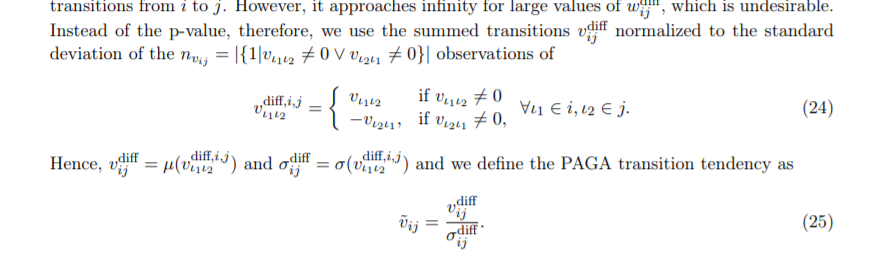

#### Correction

In [ ]:
V_ij = np.zeros((eps_ij.shape[0], eps_ij.shape[0]))
eps = 0.1
obs_thr = 10

for i in range(eps_ij.shape[0]):
    for j in range(eps_ij.shape[0]):
        clust_mask_i = (an_df.obs["leiden"] == str(i)).values
        clust_mask_j = (an_df.obs["leiden"] == str(j)).values
        clust_mask_ij = np.logical_and.outer(clust_mask_i, clust_mask_j)
        clust_mask_ji = np.logical_and.outer(clust_mask_j, clust_mask_i)

        clust_ij = weight_map[clust_mask_ij]
        clust_ij = clust_ij[clust_ij.nonzero()].A[0]
        clust_ji = weight_map[clust_mask_ji]
        clust_ji = clust_ji[clust_ji.nonzero()].A[0]

        v_ij = np.concatenate([clust_ij, -clust_ji])
        if len(v_ij) > obs_thr:
            mu_vij = np.mean(v_ij)
            std_vij = np.std(v_ij)

            V_ij[i, j] = mu_vij / (std_vij + eps)
        else:
            V_ij[i, j] = 0.0

In [ ]:
plt.imshow(V_ij, vmin=-0.5, vmax=0.5)

In [ ]:
test = copy.deepcopy(an_df)

In [ ]:
test.uns["velocity_graph"] = weight_map

In [ ]:
sc.tl.paga(test, groups="leiden", use_rna_velocity=True)

In [ ]:
test.uns

In [ ]:
sc.pl.paga(
    test,
    color=["leiden"],
    arrowsize=30,
)

In [ ]:
sc.tl.umap(test, init_pos="paga")

In [ ]:
sc.pl.umap(an_df, color="leiden", legend_loc="on data")

In [ ]:
sc.pl.paga()

In [ ]:
weight_map

In [ ]:
plt.hist(V_ij.flatten())

In [ ]:
plt.hist(v_ij, bins=50)

In [ ]:
test = 
weight_map[clust_mask_ji]

In [ ]:
test[test.nonzero()].A[0]

In [ ]:
test = an_df.obs[an_df.obs["TargetID"] == 12]

In [ ]:
get_phenotype_velocity(test)

In [ ]:
strength_idx = np.argsort(test["N Mismatch"])

In [ ]:
strength_idx

In [ ]:
df_sorted = test.iloc[strength_idx]

In [ ]:
df_sorted

In [ ]:
velocities = (
    df_sorted["Velocity Projection"][1:].values
    - df_sorted["Velocity Projection"][:-1].values
)

In [ ]:
velocities

In [ ]:
an_df[an_df.obs["Gene"] == "minC"].obs["dpt_pseudotime"]

In [ ]:
an_df[an_df.obs["Gene"] == "minC"].obs["leiden"]

In [ ]:
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(
    norm_soft_dtw_arr, n_neighbors=n_neighbors, metric="precomputed"
)

In [ ]:
an_df.obsp['distances'], an_df.obsp['connectivities'] = sc.neighbors._compute_connectivities_umap(z
    knn_indices,
    knn_dists,
    adata.shape[0],
    n_neighbors, # change to neighbors you plan to use
)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(
    mdf, n_neighbors=n_neighbors, metric="precomputed"
)
(
    adata.obsp["distances"],
    adata.obsp["connectivities"],
) = sc.neighbors._compute_connectivities_umap(
    knn_indices,
    knn_dists,
    adata.shape[0],
    n_neighbors,  # change to neighbors you plan to use
)

## KNN and Leiden

In [ ]:
gene_cluster_df = pd.read_pickle(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/2021-08-16_gene_cluster_df.pkl"
)

In [ ]:
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.metrics import cdist_soft_dtw_normalized, cdist_soft_dtw
import networkx as nx
import igraph as ig
import leidenalg
import umap


def knn_leiden_dist(dist_arr, n_neighbors=5, n_iterations=2):

    knn = skl.neighbors.NearestNeighbors(
        n_neighbors=n_neighbors + 1, metric="precomputed", algorithm="brute"
    ).fit(
        dist_arr
    )  # plus one neighbor to account for self-loops

    G = knn.kneighbors_graph(dist_arr, mode="distance")
    G[G.nonzero()] = 1.0 / (G[G.nonzero()] + 1.0)  ##Distance normalization
    G_arr = G.toarray()

    ig_G = ig.Graph.Weighted_Adjacency(G_arr, mode="undirected", loops=False)
    ig_G.vs["index"] = [i for i in range(ig_G.vcount())]
    ig_G.vs["weight"] = [1.0 for i in range(ig_G.vcount())]

    part = leidenalg.find_partition(
        ig_G,
        leidenalg.ModularityVertexPartition,
        n_iterations=n_iterations,
        weights="weight",
    )

    return G, ig_G, part


def knn_leiden_softdtw(X, n_neighbors=5, n_iterations=2):

    norm_soft_dtw_Y = cdist_soft_dtw_normalized(X)  ##This is a distance

    G, ig_G, part = knn_leiden_dist(
        norm_soft_dtw_Y, n_neighbors=n_neighbors, n_iterations=n_iterations
    )

In [ ]:
X = np.array(gene_cluster_df["Feature Vector"].tolist())
X = np.swapaxes(X, 1, 2)

In [ ]:
G, ig_G, part = knn_leiden_softdtw(X, n_neighbors=7)

In [ ]:
gene_cluster_df["Leiden Clusters"] = part.membership
gene_names = gene_cluster_df.index.tolist()

#### Global Force-Directed Layout

In [ ]:
edge_weight = 10
global_graph = part.graph
global_graph_arr = global_graph.get_adjacency_sparse()
# global_graph.vs["label"] = [gene_names[idx] for idx in global_graph.vs["index"]]
pal = ig.drawing.colors.ClusterColoringPalette(len(part))
global_graph.vs["color"] = pal.get_many(part.membership)
global_graph.vs["label"] = part.membership
global_graph.es["width"] = [item * edge_weight for item in global_graph.es["weight"]]

global_graph_umap = umap.UMAP(
    n_neighbors=5, n_components=2, metric="precomputed", min_dist=0.5
).fit_transform(global_graph_arr)
global_graph_umap_layout = [
    tuple(global_graph_umap[i]) for i in range(global_graph_umap.shape[0])
]

In [ ]:
layout = global_graph.layout("fruchterman_reingold", weights="weight")
ig.plot(global_graph, layout=layout)

#### UMAP Global Layout

In [ ]:
ig.plot(global_graph, layout=global_graph_umap_layout)

In [ ]:
edge_weight = 10
sub_graph = part.subgraph(3)
sub_graph_arr = sub_graph.get_adjacency_sparse()
sub_graph.vs["label"] = [gene_names[idx] for idx in sub_graph.vs["index"]]
sub_graph.es["width"] = [item * edge_weight for item in sub_graph.es["weight"]]

sub_graph_umap = umap.UMAP(
    n_neighbors=2, n_components=2, metric="precomputed", min_dist=0.5
).fit_transform(sub_graph_arr)
sub_graph_umap_layout = [
    tuple(sub_graph_umap[i]) for i in range(sub_graph_umap.shape[0])
]

#### Force-directed Community Layout

In [ ]:
layout = sub_graph.layout("fruchterman_reingold", weights="weight")
ig.plot(sub_graph, layout=layout)

#### UMAP Community Layout

In [ ]:
# layout = sub_graph.layout("kamada_kawai",weights="weight")
ig.plot(sub_graph, layout=sub_graph_umap_layout)

## UMAP Embedding

- might be better here to use a less filtered dataset (elim clusters?) to get a better local density estimate...

In [ ]:
import dask.array as da
from igraph.drawing.text import TextDrawer
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.metrics import cdist_soft_dtw_normalized, cdist_soft_dtw
import networkx as nx
import igraph as ig
import leidenalg
import umap


def knn_leiden_dist(dist_arr, n_neighbors=5, n_iterations=2):

    knn = skl.neighbors.NearestNeighbors(
        n_neighbors=n_neighbors + 1, metric="precomputed", algorithm="brute"
    ).fit(
        dist_arr
    )  # plus one neighbor to account for self-loops

    G = knn.kneighbors_graph(dist_arr, mode="distance")
    G[G.nonzero()] = 1.0 / (G[G.nonzero()] + 1.0)  ##Distance normalization
    G_arr = G.toarray()

    ig_G = ig.Graph.Weighted_Adjacency(G_arr, mode="undirected", loops=False)
    ig_G.vs["index"] = [i for i in range(ig_G.vcount())]
    ig_G.vs["weight"] = [1.0 for i in range(ig_G.vcount())]

    part = leidenalg.find_partition(
        ig_G,
        leidenalg.ModularityVertexPartition,
        n_iterations=n_iterations,
        weights="weight",
    )

    return G, ig_G, part


def knn_leiden_softdtw(X, n_neighbors=5, n_iterations=2):

    norm_soft_dtw_Y = cdist_soft_dtw_normalized(X)  ##This is a distance

    G, ig_G, part = knn_leiden_dist(
        norm_soft_dtw_Y, n_neighbors=n_neighbors, n_iterations=n_iterations
    )

In [ ]:
gene_cluster_df = pd.read_pickle(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/2021-08-16_gene_cluster_df.pkl"
)
gene_cluster_df_full = pd.read_pickle(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/2021-08-16_gene_cluster_df_full.pkl"
)

In [ ]:
gene_cluster_df_full.columns[:-13]

In [ ]:
zscore_traces = [
    "Kernel Trace: Birth: Volume: z score",
    "Kernel Trace: Division: Volume: z score",
    "Kernel Trace: Mean Linear Growth Rate: Volume: z score",
    "Kernel Trace: Mean Exponential Growth Rate: Volume: z score",
    "Kernel Trace: Mean: minor_axis_length: z score",
    "Kernel Trace: Mean: mCherry Intensity: z score",
    "Kernel Trace: Delta t: z score",
]

for zscore_trace in zscore_traces:
    avg_zscore = gene_cluster_df_full.apply(lambda x: np.mean(x[zscore_trace]), axis=1)
    gene_cluster_df_full[zscore_trace + ": Mean"] = avg_zscore

for zscore_trace in zscore_traces:
    max_zscore = gene_cluster_df_full.apply(lambda x: np.max(x[zscore_trace]), axis=1)
    gene_cluster_df_full[zscore_trace + ": Max"] = max_zscore

#### Ungrouped Data

In [ ]:
X = np.array(gene_cluster_df_full["Feature Vector"].tolist())
X = np.swapaxes(X, 1, 2)

In [ ]:
def parallel_norm_soft_dtw(X, chunk_size=100):
    X_dask = da.from_array(X, chunks=(chunk_size, X.shape[1], X.shape[2]))
    soft_dtw_arr = da.blockwise(
        cdist_soft_dtw, "ik", X_dask, "itd", X_dask, "ktd", concatenate=True
    ).compute()
    d_ii = np.diag(soft_dtw_arr)
    norm_soft_dtw_arr = soft_dtw_arr - (
        0.5 * (d_ii.reshape((-1, 1)) + d_ii.reshape((1, -1)))
    )
    return norm_soft_dtw_arr

In [ ]:
norm_soft_dtw_arr = parallel_norm_soft_dtw(X)

In [ ]:
n_neighbors_community = 6
n_neighbors_umap = 20
edge_weight = 10

G, ig_G, part = knn_leiden_dist(
    norm_soft_dtw_arr, n_neighbors=n_neighbors_community, n_iterations=10
)
gene_cluster_df_full["Leiden Clusters"] = part.membership
global_graph = copy.copy(part.graph)
global_graph_arr = global_graph.get_adjacency_sparse()
# global_graph.vs["label"] = [gene_names[idx] for idx in global_graph.vs["index"]]
pal = ig.drawing.colors.ClusterColoringPalette(len(part))
global_graph.vs["color"] = pal.get_many(part.membership)
global_graph.vs["size"] = [5 for i in global_graph.vs["color"]]
# global_graph.vs["label"] = part.membership
global_graph.es["width"] = [item * edge_weight for item in global_graph.es["weight"]]

global_graph_umap = umap.UMAP(
    n_neighbors=n_neighbors_umap, n_components=2, metric="precomputed"
).fit_transform(norm_soft_dtw_arr)
global_graph_umap_layout = ig.layout.Layout(
    [tuple(global_graph_umap[i]) for i in range(global_graph_umap.shape[0])]
)

graph_plot = ig.plot(global_graph, layout=global_graph_umap_layout)

In [ ]:
graph_plot

In [ ]:
def get_zscore_colors(zscores):
    cmap = mpl.cm.coolwarm
    zscore_max = max(abs(np.percentile(zscores, 1)), abs(np.percentile(zscores, 99)))
    norm = mpl.colors.Normalize(vmin=-zscore_max, vmax=zscore_max)
    zscore_colors = cmap(norm(zscores))
    return zscore_colors, cmap, norm


def umap_plot_zscore(global_graph, zscores, layout):
    color_graph = copy.deepcopy(global_graph)
    zscore_colors, cmap, norm = get_zscore_colors(zscores)
    color_graph.vs["color"] = [mpl.colors.to_rgb(item) for item in zscore_colors]
    return color_graph, layout, cmap, norm


def get_colorbar(cmap, norm):
    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

    cb = mpl.colorbar.ColorbarBase(ax, orientation="horizontal", cmap=cmap, norm=norm)

    return fig, ax


def display_zscore_map(df, graph, graph_layout, zscore_label):
    zscore_vals = df[zscore_label].tolist()
    color_graph, layout, cmap, norm = umap_plot_zscore(graph, zscore_vals, graph_layout)
    graph_plot = ig.plot(color_graph, layout=layout)
    fig, ax = get_colorbar(cmap, norm)
    return graph_plot, fig, ax


def make_zscore_file(df, graph, graph_layout, zscore_label, file_label):
    graph_plot, fig, ax = display_zscore_map(df, graph, graph_layout, zscore_label)
    graph_plot.save("./Plots/" + file_label + ".svg")
    graph_plot.save("./Plots/" + file_label + ".png")
    plt.savefig("./Plots/" + file_label + "_Cmap.png", dpi=100)

#### Label Z-scores

In [ ]:
zscore_label = "Kernel Trace: Birth: Volume: z score: Mean"
file_label = "Birth_Volume_Zscore"

make_zscore_file(
    gene_cluster_df_full,
    global_graph,
    global_graph_umap_layout,
    zscore_label,
    file_label,
)

In [ ]:
zscore_label = "Kernel Trace: Division: Volume: z score: Mean"
file_label = "Division_Volume_Zscore"

make_zscore_file(
    gene_cluster_df_full,
    global_graph,
    global_graph_umap_layout,
    zscore_label,
    file_label,
)

In [ ]:
zscore_label = "Kernel Trace: Mean Linear Growth Rate: Volume: z score: Mean"
file_label = "Linear_Growth_Zscore"

make_zscore_file(
    gene_cluster_df_full,
    global_graph,
    global_graph_umap_layout,
    zscore_label,
    file_label,
)

In [ ]:
zscore_label = "Kernel Trace: Mean Exponential Growth Rate: Volume: z score: Mean"
file_label = "Exp_Growth_Zscore"

make_zscore_file(
    gene_cluster_df_full,
    global_graph,
    global_graph_umap_layout,
    zscore_label,
    file_label,
)

In [ ]:
zscore_label = "Kernel Trace: Mean: minor_axis_length: z score: Mean"
file_label = "Width_Zscore"

make_zscore_file(
    gene_cluster_df_full,
    global_graph,
    global_graph_umap_layout,
    zscore_label,
    file_label,
)

In [ ]:
zscore_label = "Kernel Trace: Mean: mCherry Intensity: z score: Mean"
file_label = "mCherry_Zscore"

make_zscore_file(
    gene_cluster_df_full,
    global_graph,
    global_graph_umap_layout,
    zscore_label,
    file_label,
)

In [ ]:
zscore_label = "Kernel Trace: Delta t: z score: Mean"
file_label = "Division_Zscore"

make_zscore_file(
    gene_cluster_df_full,
    global_graph,
    global_graph_umap_layout,
    zscore_label,
    file_label,
)

#### Label Genes of Interest

In [ ]:
gene_list = gene_cluster_df_full["Gene"].tolist()

In [ ]:
binary_list = [True if "rps" in gene else False for gene in gene_list]

In [ ]:
def umap_plot_nodes_of_interest(
    global_graph, binary_list, layout, unselected_opacity=0.2
):
    color_dict = {False: (128, 128, 128, unselected_opacity), True: "yellow"}
    color_graph = copy.deepcopy(global_graph)
    color_graph.vs["color"] = [color_dict[item] for item in binary_list]
    outline_hex = mpl.colors.rgb2hex(
        (0.0, 0.0, 0.0, unselected_opacity), keep_alpha=True
    )
    return color_graph, layout, outline_hex


# should add gene ontology?
def highlight_cluster(
    df, graph, graph_layout, cluster_label, cluster_id, bbox=(0, 0, 600, 600)
):
    binary_list = (df[cluster_label] == cluster_id).tolist()
    color_graph, layout, outline_hex = umap_plot_nodes_of_interest(
        graph, binary_list, graph_layout
    )
    graph_plot = ig.plot(
        color_graph, layout=layout, bbox=bbox, vertex_frame_color=outline_hex
    )
    return graph_plot

In [ ]:
binary_list = [True if "fts" in gene else False for gene in gene_list]
color_graph, layout, outline_hex = umap_plot_nodes_of_interest(
    global_graph, binary_list, global_graph_umap_layout
)
ig.plot(color_graph, layout=layout, vertex_frame_color=outline_hex)

#### Ribosomal Proteins

In [ ]:
ribosomal_proteins = [
    "prmA",
    "rimM",
    "rplA",
    "rplB",
    "rplC",
    "rplD",
    "rplE",
    "rplF",
    "rplI",
    "rplJ",
    "rplK",
    "rplL",
    "rplM",
    "rplN",
    "rplO",
    "rplP",
    "rplQ",
    "rplR",
    "rplS",
    "rplT",
    "rplU",
    "rplV",
    "rplW",
    "rplX",
    "rplY",
    "rpmA",
    "rpmB",
    "rpmC",
    "rpmD",
    "rpmE",
    "rpmF",
    "rpmG",
    "rpmH",
    "rpmI",
    "rpmJ",
    "rpsA",
    "rpsB",
    "rpsC",
    "rpsD",
    "rpsE",
    "rpsF",
    "rpsG",
    "rpsH",
    "rpsI",
    "rpsJ",
    "rpsK",
    "rpsL",
    "rpsM",
    "rpsN",
    "rpsO",
    "rpsP",
    "rpsQ",
    "rpsR",
    "rpsS",
    "rpsT",
    "rpsU",
    "sra",
    "ykgM",
    "ykgO",
]

binary_list = gene_cluster_df_full["Gene"].isin(ribosomal_proteins).tolist()
color_graph, layout, outline_hex = umap_plot_nodes_of_interest(
    global_graph, binary_list, global_graph_umap_layout
)
ig.plot(
    color_graph, layout=layout, vertex_frame_color=outline_hex, bbox=(0, 0, 400, 400)
)

In [ ]:
ribosome_df = gene_cluster_df_full[
    gene_cluster_df_full["Gene"].isin(ribosomal_proteins)
]

In [ ]:
ribosome_genes, ribosome_gene_counts = np.unique(
    ribosome_df[ribosome_df["Leiden Clusters"] == 0]["Gene"].tolist(),
    return_counts=True,
)
ribosome_genes = [
    str(ribosome_genes[i]) + ":" + str(ribosome_gene_counts[i])
    for i in range(len(ribosome_genes))
]


gene_names = " ".join(sorted(ribosome_genes))
print(textwrap.fill(gene_names, 50))

In [ ]:
ribosome_genes, ribosome_gene_counts = np.unique(
    ribosome_df[ribosome_df["Leiden Clusters"] == 6]["Gene"].tolist(),
    return_counts=True,
)
ribosome_genes = [
    str(ribosome_genes[i]) + ":" + str(ribosome_gene_counts[i])
    for i in range(len(ribosome_genes))
]


gene_names = " ".join(sorted(ribosome_genes))
print(textwrap.fill(gene_names, 50))

#### rplKAJLrpoBC Operon

In [ ]:
rplKAJLrpoBC_df = gene_cluster_df_full[
    gene_cluster_df_full["Gene"].isin(["rplK", "rplA", "rplJ", "rplL", "rpoB", "rpoC"])
]

In [ ]:
rplKAJLrpoBC_df[rplKAJLrpoBC_df["Gene"] == "rpoC"]

In [ ]:
ribosome_df[ribosome_df["Gene"] == "rplJ"]

#### RNA Polymerase

In [ ]:
rnapol_genes = gene_cluster_df_full["Gene"].isin(["rpoZ"]).tolist()
color_graph, layout, outline_hex = umap_plot_nodes_of_interest(
    global_graph, rnapol_genes, global_graph_umap_layout
)
ig.plot(
    color_graph, layout=layout, vertex_frame_color=outline_hex, bbox=(0, 0, 400, 400)
)

In [ ]:
rpoA

In [ ]:
ribosomal_rnas = ["rrf", "rrs", "rrl"]

binary_list = (
    gene_cluster_df_full["Gene"]
    .apply(lambda x: np.any([rna in x for rna in ribosomal_rnas]))
    .tolist()
)
color_graph, layout, outline_hex = umap_plot_nodes_of_interest(
    global_graph, binary_list, global_graph_umap_layout
)
ig.plot(
    color_graph, layout=layout, vertex_frame_color=outline_hex, bbox=(0, 0, 400, 400)
)

In [ ]:
ribosomal_rnas = ["rrl"]

binary_list = (
    gene_cluster_df_full["Gene"]
    .apply(lambda x: np.any([rna in x for rna in ribosomal_rnas]))
    .tolist()
)
color_graph, layout, outline_hex = umap_plot_nodes_of_interest(
    global_graph, binary_list, global_graph_umap_layout
)
ig.plot(
    color_graph, layout=layout, vertex_frame_color=outline_hex, bbox=(0, 0, 400, 400)
)

In [ ]:
ribosome_rna_df = gene_cluster_df_full[
    gene_cluster_df_full["Gene"].apply(
        lambda x: np.any([rna in x for rna in ribosomal_rnas])
    )
]

In [ ]:
ribosome_rna_df["Gene"].tolist()

#### fts Proteins

In [ ]:
rnapol_genes = gene_cluster_df_full['Gene'].isin(["rpoZ"]).tolist()
color_graph,layout,outline_hex = umap_plot_nodes_of_interest(global_graph,rnapol_genes,global_graph_umap_layout)
ig.plot(color_graph,layout = layout, vertex_frame_color=outline_hex, bbox=(0,0,400,400))rnapol_genes = gene_cluster_df_full['Gene'].isin(["rpoZ"]).tolist()
color_graph,layout,outline_hex = umap_plot_nodes_of_interest(global_graph,rnapol_genes,global_graph_umap_layout)
ig.plot(color_graph,layout = layout, vertex_frame_color=outline_hex, bbox=(0,0,400,400))

In [ ]:
ribosome_genes, ribosome_gene_counts = np.unique(
    ribosome_rna_df[ribosome_rna_df["Leiden Clusters"] == 0]["Gene"].tolist(),
    return_counts=True,
)
ribosome_genes = [
    str(ribosome_genes[i]) + ":" + str(ribosome_gene_counts[i])
    for i in range(len(ribosome_genes))
]


gene_names = " ".join(sorted(ribosome_genes))
print(textwrap.fill(gene_names, 50))

#### GO Enrichment

In [ ]:
import goatools
import goatools.base
from goatools.base import download_go_basic_obo

from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader
from goatools.semantic import semantic_similarity
from goatools.semantic import TermCounts, get_info_content

from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.go_enrichment import GOEnrichmentStudy

In [ ]:
# Get ontologies
obo_fname = download_go_basic_obo()

In [ ]:
# Get ecoli association file (ecocyc)
gaf_handle = goatools.base.http_get(
    "http://current.geneontology.org/annotations/ecocyc.gaf.gz", fout="./ecocyc.gaf.gz"
)
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

In [ ]:
## Getting ontologies and other nonesense

obodag = GODag(obo_fname)
objanno = GafReader(gaf_fname)
ns2assoc = objanno.get_ns2assc()

gene_to_id = {assoc.DB_Symbol: assoc.DB_ID for assoc in objanno.associations}
inv_gene_to_id = {assoc.DB_ID: assoc.DB_Symbol for assoc in objanno.associations}
synonym_dict = {
    synonym: assoc.DB_ID
    for assoc in objanno.associations
    for synonym in assoc.DB_Synonym
}
gene_to_id.update(synonym_dict)

# background gene set

all_genes = gene_cluster_df_full["Gene"].unique().tolist()

In [ ]:
def get_enriched_GO_terms(
    background_gene_list, gene_list, obodag, objanno, ns2assoc, pval=0.05, GO_type="BP"
):

    gene_to_id = {assoc.DB_Symbol: assoc.DB_ID for assoc in objanno.associations}
    synonym_dict = {
        synonym: assoc.DB_ID
        for assoc in objanno.associations
        for synonym in assoc.DB_Synonym
    }
    gene_to_id.update(synonym_dict)

    # background gene set

    all_genes_uniprot = [
        gene_to_id[item] for item in background_gene_list if item in gene_to_id.keys()
    ]
    selected_genes_uniprot = [
        gene_to_id[item] for item in gene_list if item in gene_to_id.keys()
    ]

    print(len(all_genes_uniprot))
    print(len(selected_genes_uniprot))

    goeaobj = GOEnrichmentStudy(
        all_genes_uniprot,  # List of mouse protein-coding genes
        ns2assoc[GO_type],  # geneid/GO associations
        obodag,  # Ontologies
        propagate_counts=True,
        alpha=pval,  # default significance cut-off
        methods=["fdr_bh"],
    )
    # defult multipletest correction method

    goea_results_all = goeaobj.run_study(selected_genes_uniprot, prt=None)
    goea_quiet_sig = [r for r in goea_results_all if r.p_fdr_bh < pval]
    goea_quiet_enriched = [r for r in goea_quiet_sig if r.enrichment == "e"]
    return goea_quiet_enriched


def pick_exemplar(go1, go2, termcounts, obodag, info_thr, pval_factor=2.0):

    info_1_low = get_info_content(go1.GO, termcounts) < info_thr
    info_2_low = get_info_content(go2.GO, termcounts) < info_thr
    if info_1_low and not info_2_low:
        return go2
    elif info_2_low and not info_1_low:
        return go1
    elif info_2_low and info_1_low:
        return go1

    pval_ratio = go1.p_fdr_bh / go2.p_fdr_bh

    if pval_ratio > pval_factor:
        return go2
    elif pval_ratio < (1.0 / pval_factor):
        return go1

    go1_parents = list(obodag[go1.GO].get_all_parents())
    go2_parents = list(obodag[go2.GO].get_all_parents())

    if go2.GO in go1_parents:
        return go2

    elif go1.GO in go2_parents:
        return go1

    return go1


def get_filtered_go_terms(
    obodag, objanno, goea_list, sim_thr=0.05, info_thr=1.0, GO_type="BP"
):

    termcounts = TermCounts(obodag, objanno.get_ns2assc()[GO_type])

    go_term_list = [item.GO for item in goea_list]
    sim_arr = np.zeros((len(go_term_list), len(go_term_list)))
    for i in range(len(go_term_list)):
        for j in range(len(go_term_list)):
            sim_arr[i, j] = semantic_similarity(
                go_term_list[i], go_term_list[j], obodag
            )
    np.fill_diagonal(sim_arr, 0.0)

    working_group_idx = 0
    grouped_terms = {}
    group_exemplars = {}
    go_term_indices = list(range(len(go_term_list)))

    while len(go_term_indices) > 0:
        i = go_term_indices[0]
        most_sim_arg = np.argmax(sim_arr[i])
        sim_score = sim_arr[i, most_sim_arg]
        if sim_score > sim_thr:
            if len(grouped_terms) > 0:
                in_other_group_keys = [
                    key for key, val in grouped_terms.items() if most_sim_arg in val
                ]
                if len(in_other_group_keys) == 1:
                    other_group_idx = in_other_group_keys[0]
                    grouped_terms[other_group_idx] = grouped_terms[other_group_idx] + [
                        i
                    ]
                    group_exemplars[other_group_idx] = pick_exemplar(
                        group_exemplars[other_group_idx],
                        goea_list[i],
                        termcounts,
                        obodag,
                        info_thr,
                    )
                else:
                    grouped_terms[working_group_idx] = [i, most_sim_arg]
                    group_exemplars[working_group_idx] = pick_exemplar(
                        goea_list[i],
                        goea_list[most_sim_arg],
                        termcounts,
                        obodag,
                        info_thr,
                    )
                    working_group_idx += 1
                    go_term_indices.remove(most_sim_arg)
            else:
                grouped_terms[working_group_idx] = [i, most_sim_arg]
                group_exemplars[working_group_idx] = pick_exemplar(
                    goea_list[i], goea_list[most_sim_arg], termcounts, obodag, info_thr
                )
                working_group_idx += 1
                go_term_indices.remove(most_sim_arg)
        go_term_indices.remove(i)

    group_exemplars = list(group_exemplars.values())

    return group_exemplars


def get_GO_assign_dict(selected_goea, cluster_genes_uniprot):
    all_study_items = copy.copy(cluster_genes_uniprot)
    depth_list = sorted(set([item.depth for item in selected_goea]))[::-1]
    assign_dict = {}
    for depth in depth_list:
        go_terms_at_level = [item for item in selected_goea if item.depth == depth]
        for go_term in go_terms_at_level:
            study_item_list = list(go_term.study_items)
            for study_item in study_item_list:
                if study_item in all_study_items:
                    assign_dict[study_item] = go_term.name
                    all_study_items.remove(study_item)

    for remaining_item in all_study_items:
        assign_dict[remaining_item] = "Unassigned"

    return assign_dict


def plot_cluster_timeseries(
    df,
    cluster_label,
    cluster_subset=None,
    feature_vector_label="Feature Vector",
    feature_labels=[
        "Birth: Volume",
        "Division: Volume",
        "Mean Linear Growth Rate: Volume",
        "Mean Exponential Growth Rate: Volume",
        "Mean: minor_axis_length",
        "Mean: mCherry Intensity",
        "Delta t",
    ],
    figsize=(10, 10),
    wspace=0.0,
    fontsize=18,
    linewidth=5,
):

    if cluster_subset is not None:
        df = copy.copy(df)
        df = df[df[cluster_label].isin(cluster_subset)]

    mean_cluster_timeseries = df.groupby([cluster_label]).apply(
        lambda x: np.mean(np.array(x[feature_vector_label].tolist()), axis=0)
    )
    # Compute and plot dendrogram.
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(1, len(mean_cluster_timeseries), wspace=wspace)

    for i, idx in enumerate(mean_cluster_timeseries.index):
        clust_arr = np.array(mean_cluster_timeseries[idx])

        if i == 0:
            inner_gs = gs[0, i].subgridspec(
                clust_arr.shape[0],
                1,
                wspace=0,
                hspace=0,
            )
            inner_grid_sub = inner_gs.subplots(sharex=True)
            for c, ax in np.ndenumerate(inner_grid_sub):
                ax.plot(clust_arr[c], linewidth=linewidth)
                ax.set_ylim(-4, 8)
                ax.set(xticks=[], yticks=[0, 6])
                ax.set_ylabel(
                    feature_labels[c[0]],
                    rotation=0,
                    labelpad=30,
                    fontsize=fontsize,
                    ha="right",
                )  # ,orientation="horizontal")

            ax.set_xlabel(str(idx), fontsize=fontsize)

        else:
            inner_gs = gs[0, i].subgridspec(clust_arr.shape[0], 1, wspace=0, hspace=0)
            inner_grid_sub = inner_gs.subplots(sharex=True)
            for c, ax in np.ndenumerate(inner_grid_sub):
                ax.plot(clust_arr[c], linewidth=linewidth)
                ax.set_ylim(-4, 8.0)
                ax.set(xticks=[], yticks=[])

            ax.set_xlabel(str(idx), fontsize=fontsize)

    plt.tight_layout()

In [ ]:
clust_id = 0
cluster_genes = sorted(
    gene_cluster_df_full[gene_cluster_df_full["Leiden Clusters"] == clust_id]["Gene"]
    .unique()
    .tolist()
)

goea_quiet_enriched = get_enriched_GO_terms(
    all_genes, cluster_genes, obodag, objanno, ns2assoc, pval=0.05, GO_type="BP"
)
filtered_go_terms = get_filtered_go_terms(
    obodag, objanno, goea_quiet_enriched, sim_thr=0.3, info_thr=1.0
)

In [ ]:
clust_id = 17
cluster_genes = sorted(
    gene_cluster_df_full[gene_cluster_df_full["Leiden Clusters"] == clust_id][
        "Gene"
    ].tolist()
)
cluster_genes, cluster_gene_counts = np.unique(cluster_genes, return_counts=True)
cluster_genes = [
    str(cluster_genes[i]) + ":" + str(cluster_gene_counts[i])
    for i in range(len(cluster_genes))
]


gene_names = " ".join(sorted(cluster_genes))
print(textwrap.fill(gene_names, 50))

In [ ]:
cluster_gene_counts

In [ ]:
import textwrap

In [ ]:
clust_id = 7
cluster_genes = sorted(
    gene_cluster_df_full[gene_cluster_df_full["Leiden Clusters"] == clust_id]["Gene"]
    .unique()
    .tolist()
)

goea_quiet_enriched = get_enriched_GO_terms(
    all_genes, cluster_genes, obodag, objanno, ns2assoc, pval=0.05, GO_type="BP"
)
filtered_go_terms = get_filtered_go_terms(
    obodag, objanno, goea_quiet_enriched, sim_thr=0.3, info_thr=1.0
)

cluster_graph = highlight_cluster(
    gene_cluster_df_full,
    global_graph,
    global_graph_umap_layout,
    "Leiden Clusters",
    clust_id,
    bbox=(0, 0, 500, 500),
)
print("")
for go_term in filtered_go_terms:
    print(str(go_term.name) + ": P-val: " + str(go_term.p_fdr_bh))
    print(
        "Percent of this GO Term: "
        + str(go_term.ratio_in_study[0] / go_term.ratio_in_pop[0])
    )
    gene_names = " ".join(
        sorted([inv_gene_to_id[item] for item in go_term.study_items])
    )
    print(textwrap.fill(gene_names, 80))
    print("")


cluster_graph

In [ ]:
plot_cluster_timeseries(
    gene_cluster_df_full, "Leiden Clusters", cluster_subset=[0, 12, 17], figsize=(8, 8)
)

In [ ]:
feature_labels = [
    "Birth: Volume",
    "Division: Volume",
    "Mean Linear Growth Rate: Volume",
    "Mean Exponential Growth Rate: Volume",
    "Mean: minor_axis_length",
    "Mean: mCherry Intensity",
    "Delta t",
]


fig = plt.figure(figsize=(12, 12))

for i in range(len(feature_labels)):
    ax = plt.subplot(3, 3, i + 1)
    ax.set_title(feature_labels[i])
    ax.plot(
        np.array(
            gene_cluster_df_full[gene_cluster_df_full["Leiden Clusters"] == 17][
                "Feature Vector"
            ].tolist()
        )[:, i, :].T,
        c="tab:blue",
    )
plt.show()

In [ ]:
gene_cluster_df_full[gene_cluster_df_full["Leiden Clusters"] == 17]["sgRNA"]

In [ ]:
gene_cluster_df_full[gene_cluster_df_full["Leiden Clusters"] == 17]["Gene"]

In [ ]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.go_enrichment import GOEnrichmentStudy

pval = 0.05
GO_type = "BP"

clust_id = 4
cluster_genes = sorted(
    gene_cluster_df_full[gene_cluster_df_full["Leiden Clusters"] == clust_id]["Gene"]
    .unique()
    .tolist()
)
cluster_genes_uniprot = [
    gene_to_id[item] for item in cluster_genes if item in gene_to_id.keys()
]

goeaobj = GOEnrichmentStudy(
    all_genes_uniprot,  # List of mouse protein-coding genes
    ns2assoc[GO_type],  # geneid/GO associations
    obodag,  # Ontologies
    propagate_counts=True,
    alpha=pval,  # default significance cut-off
    methods=["fdr_bh"],
)  # defult multipletest correction method

goea_results_all = goeaobj.run_study(cluster_genes_uniprot, prt=None)
goea_quiet_sig = [r for r in goea_results_all if r.p_fdr_bh < pval]
goea_quiet_enriched = [r for r in goea_quiet_sig if r.enrichment == "e"]
# #reloading corrupted items (GOEnrichmentStudy messes them up)
# obodag = GODag(obo_fname)
# ns2assoc = objanno.get_ns2assc()

# parent_goeaobj = GOEnrichmentStudy(
#         all_genes_uniprot, # List of mouse protein-coding genes
#         ns2assoc[GO_type], # geneid/GO associations
#         obodag, # Ontologies
#         propagate_counts = False,
#         alpha = pval, # default significance cut-off
#         methods=["fdr_bh"]) # defult multipletest correction method

# parent_goea_results_all = parent_goeaobj.run_study(cluster_genes_uniprot, prt=None)
# parent_goea_quiet_sig = [r for r in parent_goea_results_all if r.p_fdr_bh < pval]

# parent_goeaobj = GOEnrichmentStudyNS(
#         all_genes_uniprot, # List of mouse protein-coding genes
#         ns2assoc, # geneid/GO associations
#         obodag, # Ontologies
#         propagate_counts = False,
#         alpha = pval, # default significance cut-off
#         methods=["fdr_bh"]) # defult multipletest correction method

In [ ]:
print(
    "{N} of {M:,} results were significant".format(
        N=len(goea_quiet_sig), M=len(goea_results_all)
    )
)

In [ ]:
print(
    "Significant results: {E} enriched, {P} purified".format(
        E=sum(1 for r in goea_quiet_sig if r.enrichment == "e"),
        P=sum(1 for r in goea_quiet_sig if r.enrichment == "p"),
    )
)

In [ ]:
from goatools.semantic import semantic_similarity
from goatools.semantic import TermCounts, get_info_content

termcounts = TermCounts(obodag, objanno.get_ns2assc()[GO_type])
go_id3 = "GO:0051301"
go_id4 = "GO:0071103"

sim = semantic_similarity(go_id3, go_id4, obodag)
print(
    "The semantic similarity between terms {} and {} is {}.".format(go_id3, go_id4, sim)
)

In [ ]:
objanno

In [ ]:
from goatools.semantic import semantic_similarity
from goatools.semantic import TermCounts, get_info_content


def pick_exemplar(go1, go2, termcounts, obodag, info_thr, pval_factor=2.0):

    info_1_low = get_info_content(go1.GO, termcounts) < info_thr
    info_2_low = get_info_content(go2.GO, termcounts) < info_thr
    if info_1_low and not info_2_low:
        return go2
    elif info_2_low and not info_1_low:
        return go1
    elif info_2_low and info_1_low:
        return go1

    pval_ratio = go1.p_fdr_bh / go2.p_fdr_bh

    if pval_ratio > pval_factor:
        return go2
    elif pval_ratio < (1.0 / pval_factor):
        return go1

    go1_parents = list(obodag[go1.GO].get_all_parents())
    go2_parents = list(obodag[go2.GO].get_all_parents())

    if go2.GO in go1_parents:
        return go2

    elif go1.GO in go2_parents:
        return go1

    return go1


def get_filtered_go_terms(
    obodag, objanno, goea_list, sim_thr=0.05, info_thr=1.0, GO_type="BP"
):

    termcounts = TermCounts(obodag, objanno.get_ns2assc()[GO_type])

    go_term_list = [item.GO for item in goea_list]
    sim_arr = np.zeros((len(go_term_list), len(go_term_list)))
    for i in range(len(go_term_list)):
        for j in range(len(go_term_list)):
            sim_arr[i, j] = semantic_similarity(
                go_term_list[i], go_term_list[j], obodag
            )
    np.fill_diagonal(sim_arr, 0.0)

    working_group_idx = 0
    grouped_terms = {}
    group_exemplars = {}
    go_term_indices = list(range(len(go_term_list)))

    while len(go_term_indices) > 0:
        i = go_term_indices[0]
        most_sim_arg = np.argmax(sim_arr[i])
        sim_score = sim_arr[i, most_sim_arg]
        if sim_score > sim_thr:
            if len(grouped_terms) > 0:
                in_other_group_keys = [
                    key for key, val in grouped_terms.items() if most_sim_arg in val
                ]
                if len(in_other_group_keys) == 1:
                    other_group_idx = in_other_group_keys[0]
                    grouped_terms[other_group_idx] = grouped_terms[other_group_idx] + [
                        i
                    ]
                    group_exemplars[other_group_idx] = pick_exemplar(
                        group_exemplars[other_group_idx],
                        goea_list[i],
                        termcounts,
                        obodag,
                        info_thr,
                    )
                else:
                    grouped_terms[working_group_idx] = [i, most_sim_arg]
                    group_exemplars[working_group_idx] = pick_exemplar(
                        goea_list[i],
                        goea_list[most_sim_arg],
                        termcounts,
                        obodag,
                        info_thr,
                    )
                    working_group_idx += 1
                    go_term_indices.remove(most_sim_arg)
            else:
                grouped_terms[working_group_idx] = [i, most_sim_arg]
                group_exemplars[working_group_idx] = pick_exemplar(
                    goea_list[i], goea_list[most_sim_arg], termcounts, obodag, info_thr
                )
                working_group_idx += 1
                go_term_indices.remove(most_sim_arg)
        go_term_indices.remove(i)

    group_exemplars = list(group_exemplars.values())

    return group_exemplars


def get_GO_assign_dict(selected_goea, cluster_genes_uniprot):
    all_study_items = copy.copy(cluster_genes_uniprot)
    depth_list = sorted(set([item.depth for item in selected_goea]))[::-1]
    assign_dict = {}
    for depth in depth_list:
        go_terms_at_level = [item for item in selected_goea if item.depth == depth]
        for go_term in go_terms_at_level:
            study_item_list = list(go_term.study_items)
            for study_item in study_item_list:
                if study_item in all_study_items:
                    assign_dict[study_item] = go_term.name
                    all_study_items.remove(study_item)

    for remaining_item in all_study_items:
        assign_dict[remaining_item] = "Unassigned"

    return assign_dict

In [ ]:
filtered_go_terms = get_filtered_go_terms(
    obodag, objanno, goea_quiet_enriched, sim_thr=0.05, info_thr=1.0
)

In [ ]:
test = filtered_go_terms[0]

In [ ]:
filtered_go_terms = get_filtered_go_terms(
    obodag, objanno, goea_quiet_enriched, sim_thr=0.3, info_thr=1.0
)
ttl = 0
for item in filtered_go_terms:
    print(item.name)
    print(item.study_count)
    ttl += item.study_count

In [ ]:
all_study_items = copy.copy(cluster_genes_uniprot)
assign_dict = {}
for study_item in all_study_items:
    valid_go_terms = []
    for go_term in filtered_go_terms:
        if study_item in go_term.study_items:
            valid_go_terms.append(go_term)
    if len(valid_go_terms) == 0:
        assign_dict[study_item] = "Unassigned"
    elif len(valid_go_terms) == 1:
        assign_dict[study_item] = valid_go_terms[0].name
    else:
        go_ex = pick_exemplar(
            valid_go_terms[0],
            valid_go_terms[1],
            termcounts,
            obodag,
            info_thr,
            pval_factor=2.0,
        )
        for i in range(len(valid_go_terms) - 2):
            go_ex = pick_exemplar(
                go_ex,
                valid_go_terms[i + 2],
                termcounts,
                obodag,
                info_thr,
                pval_factor=2.0,
            )
        assign_dict[study_item] = go_ex.name
# depth_list = sorted(set([item.depth for item in selected_goea]))[::-1]
# assign_dict = {}
# for depth in depth_list:
#     go_terms_at_level = [item for item in selected_goea if item.depth == depth]
#     for go_term in go_terms_at_level:
#         study_item_list = list(go_term.study_items)
#         for study_item in study_item_list:
#             if study_item in all_study_items:
#                 assign_dict[study_item] = go_term.name
#                 all_study_items.remove(study_item)

# for remaining_item in all_study_items:
#     assign_dict[remaining_item] = "Unassigned"

In [ ]:
assign_dict

In [ ]:
len([key for key, val in assign_dict.items() if val != "Unassigned"])

In [ ]:
item.

In [ ]:
print([item.study_count for item in goea_quiet_sig])

In [ ]:
print([item.study_n for item in goea_quiet_sig])

In [ ]:
print([item.pop_count for item in goea_quiet_sig])

In [ ]:
item.enrichment

In [ ]:
from goatools.semantic import TermCounts, get_info_content

# First get the counts of each GO term.
termcounts = TermCounts(obodag, objanno.get_ns2assc()[GO_type])

# Calculate the information content
go_id = "GO:0051301"
infocontent = get_info_content(go_id, termcounts)
print("Information content ({}) = {}".format(go_id, infocontent))

Each GO term is grouped with its most similar term if their pairwise semantic similarity score is higher than or equal to a user-adjustable threshold value. One GO term is then selected as the representative of the group following the logical reasoning outlined below. If the most similar term is already part of another group, then the GO term is added to this group and a representative term is selected between the newly added GO term or the current representative of the group. This process is repeated for all GO terms provided in the list from the enrichment analysis, resulting in groups of GO terms represented by a single term, based on their semantic similarities, with user-control over the resolution of redundancy reduction. GO terms with no other term above the semantic similarity score threshold remain as singletons on the scatterplot. Representative selection is based on the following stepwise logical

In [ ]:
similarity_thr = 1.0

In [ ]:
goea_quiet_sig[0].GO

In [ ]:
bioproc_goea = [item for item in goea_quiet_sig if item.NS == "BP"]
bioproc_parent_goea = [item for item in parent_goea_quiet_sig if item.NS == "BP"]

In [ ]:
def get_GO_assign_dict(selected_goea, cluster_genes_uniprot):
    all_study_items = copy.copy(cluster_genes_uniprot)
    depth_list = sorted(set([item.depth for item in selected_goea]))[::-1]
    assign_dict = {}
    for depth in depth_list:
        go_terms_at_level = [item for item in selected_goea if item.depth == depth]
        for go_term in go_terms_at_level:
            study_item_list = list(go_term.study_items)
            for study_item in study_item_list:
                if study_item in all_study_items:
                    assign_dict[study_item] = go_term.name
                    all_study_items.remove(study_item)

    for remaining_item in all_study_items:
        assign_dict[remaining_item] = "Unassigned"

    return assign_dict

    # signif_item_list = [list(item.study_items) for item in bioproc_goea]

In [ ]:
goea_quiet_sig.

In [ ]:
assign_dict = get_GO_assign_dict(bioproc_goea, cluster_genes_uniprot)
parent_assign_dict = get_GO_assign_dict(bioproc_parent_goea, cluster_genes_uniprot)

In [ ]:
test = goea_quiet_sig[0]

In [ ]:
ratio_arr = np.array(
    [item.ratio_in_pop[0] / item.ratio_in_pop[1] for item in goea_quiet_sig]
)
norm_ratio_arr = ratio_arr / np.sum(ratio_arr)

In [ ]:
norm_ratio_arr

In [ ]:
for item in goea_results_sig:
    print(item.name)

In [ ]:
signif_item_list

In [ ]:
test.namespace2NS

In [ ]:
test.NS

In [ ]:
test.name

In [ ]:
test.study_items

In [ ]:
test = goea_results_sig[1]

In [ ]:
test.depth

In [ ]:
test.name

In [ ]:
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

In [ ]:
mean_cluster_timeseries = gene_cluster_df_full.groupby(["Leiden Clusters"]).apply(
    lambda x: np.mean(np.array(x["Feature Vector"].tolist()), axis=0)
)

In [ ]:
gene_cluster_df_full.columns

In [ ]:
def plot_cluster_timeseries(
    df,
    cluster_label,
    feature_vector_label="Feature Vector",
    feature_labels=[
        "Birth: Volume",
        "Division: Volume",
        "Mean Linear Growth Rate: Volume",
        "Mean Exponential Growth Rate: Volume",
        "Mean: minor_axis_length",
        "Mean: mCherry Intensity",
        "Delta t",
    ],
    figsize=(10, 10),
    wspace=0.0,
    fontsize=18,
    linewidth=5,
):

    mean_cluster_timeseries = df.groupby([cluster_label]).apply(
        lambda x: np.mean(np.array(x[feature_vector_label].tolist()), axis=0)
    )

    # Compute and plot dendrogram.
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(1, len(mean_cluster_timeseries), wspace=wspace)

    for i in range(len(mean_cluster_timeseries)):
        clust_arr = np.array(mean_cluster_timeseries[i])

        if i == 0:
            inner_gs = gs[0, i].subgridspec(
                clust_arr.shape[0],
                1,
                wspace=0,
                hspace=0,
            )
            inner_grid_sub = inner_gs.subplots(sharex=True)
            for c, ax in np.ndenumerate(inner_grid_sub):
                ax.plot(clust_arr[c], linewidth=linewidth)
                ax.set_ylim(-4, 8)
                ax.set(xticks=[], yticks=[0, 6])
                ax.set_ylabel(
                    feature_labels[c[0]],
                    rotation=0,
                    labelpad=30,
                    fontsize=fontsize,
                    ha="right",
                )  # ,orientation="horizontal")

            ax.set_xlabel("Cluster " + str(i), fontsize=fontsize)

        else:
            inner_gs = gs[0, i].subgridspec(clust_arr.shape[0], 1, wspace=0, hspace=0)
            inner_grid_sub = inner_gs.subplots(sharex=True)
            for c, ax in np.ndenumerate(inner_grid_sub):
                ax.plot(clust_arr[c], linewidth=linewidth)
                ax.set_ylim(-4, 8.0)
                ax.set(xticks=[], yticks=[])

            ax.set_xlabel("Cluster " + str(i), fontsize=fontsize)

    plt.tight_layout()

In [ ]:
plot_cluster_timeseries(gene_cluster_df_full, figsize=(20, 10))

#### Subgroups

In [ ]:
def highlight_cluster(df, graph, graph_layout, cluster_label, cluster_id):
    binary_list = (df[cluster_label] == cluster_id).tolist()
    color_graph, layout, outline_hex = umap_plot_nodes_of_interest(
        graph, binary_list, graph_layout
    )
    graph_plot = ig.plot(color_graph, layout=layout, vertex_frame_color=outline_hex)
    return graph_plot

In [ ]:
graph_plot = highlight_cluster(
    gene_cluster_df_full, global_graph, global_graph_umap_layout, "Leiden Clusters", 4
)
graph_plot

In [ ]:
subgraph = part.subgraph(3)
subgraph_layout = (
    np.array(global_graph_umap_layout.coords)[np.array(part.membership) == 3]
).tolist()

In [ ]:
cluster_df = gene_cluster_df_full[gene_cluster_df_full["Leiden Clusters"] == 0]

In [ ]:
def get_df_umap(df, feature_label, n_neighbors=10, n_iterations=10, edge_weight=10):

    X = np.array(df[feature_label].tolist())
    X = np.swapaxes(X, 1, 2)

    norm_soft_dtw_arr = parallel_norm_soft_dtw(X)

    G, ig_G, part = knn_leiden_dist(
        norm_soft_dtw_arr, n_neighbors=n_neighbors, n_iterations=n_iterations
    )

    graph = copy.copy(part.graph)

    pal = ig.drawing.colors.ClusterColoringPalette(len(part))
    graph.vs["color"] = pal.get_many(part.membership)
    graph.vs["size"] = [5 for i in graph.vs["color"]]
    graph.es["width"] = [item * edge_weight for item in graph.es["weight"]]

    graph_umap = umap.UMAP(
        n_neighbors=n_neighbors, n_components=2, metric="precomputed"
    ).fit_transform(norm_soft_dtw_arr)
    umap_layout = ig.layout.Layout(
        [tuple(graph_umap[i]) for i in range(graph_umap.shape[0])]
    )

    return graph, umap_layout, part

In [ ]:
cluster_df = gene_cluster_df_full[gene_cluster_df_full["Leiden Clusters"] == 0]
graph, umap_layout, cluster_part = get_df_umap(cluster_df, "Feature Vector")
cluster_df["Subgraph Clusters"] = cluster_part.membership

In [ ]:
gene_list = cluster_df["Gene"].tolist()

In [ ]:
gene_list

In [ ]:
genes, gene_counts = np.unique(gene_list, return_counts=True)
genes = [str(genes[i]) + ":" + str(gene_counts[i]) for i in range(len(genes))]


gene_names = " ".join(sorted(genes))
print(textwrap.fill(gene_names, 50))

In [ ]:
graph_plot = ig.plot(graph, layout=umap_layout)

In [ ]:
graph_plot

In [ ]:
plot_cluster_timeseries(cluster_df, "Subgraph Clusters")

In [ ]:
graph_plot = highlight_cluster(cluster_df, graph, umap_layout, "Subgraph Clusters", 1)
graph_plot

In [ ]:
binary_list = [
    True if "rpoC" in gene else False for gene in cluster_df["Gene"].tolist()
]
color_graph, layout, outline_hex = umap_plot_nodes_of_interest(
    graph, binary_list, umap_layout
)
ig.plot(color_graph, layout=layout, vertex_frame_color=outline_hex)

In [ ]:
genes_in_clusters = cluster_df.groupby("Subgraph Clusters").apply(
    lambda x: x["Gene"].unique().tolist()
)

In [ ]:
print(sorted(set([val for item in genes_in_clusters[0:4] for val in item])))

In [ ]:
print(sorted(genes_in_clusters[4]))

In [ ]:
zscore_label = "Kernel Trace: Mean: mCherry Intensity: z score: Mean"
file_label = "Subgraph_3_mCherry_Zscore"

make_zscore_file(cluster_df, graph, umap_layout, zscore_label, file_label)

In [ ]:
np.array(cluster_df["Kernel Trace: Birth: Volume: z score"].tolist())

In [ ]:
plt.plot(
    np.array(cluster_df["Kernel Trace: Mean: mCherry Intensity: z score"].tolist()).T,
    c="blue",
    alpha=0.1,
)
plt.show()

In [ ]:
plt.plot(
    np.array(
        cluster_df[cluster_df["Subgraph Clusters"] == 4][
            "Kernel Trace: Birth: Volume: z score"
        ].tolist()[:3]
    ).T,
    c="blue",
    alpha=0.1,
)
plt.show()

In [ ]:
sns.lineplot(
    cluster_df["Kernel Trace: Birth: Volume: z score"],
)

In [ ]:
binary_list = [True if "fts" in gene else False for gene in gene_list]
color_graph, layout, outline_hex = umap_plot_nodes_of_interest(
    global_graph, binary_list, global_graph_umap_layout
)
ig.plot(color_graph, layout=layout, vertex_frame_color=outline_hex)

In [ ]:
[
    "Kernel Trace: Division: Volume: z score",
    "Kernel Trace: Mean Linear Growth Rate: Volume: z score",
    "Kernel Trace: Mean Exponential Growth Rate: Volume: z score",
    "Kernel Trace: Mean: minor_axis_length: z score",
    "Kernel Trace: Mean: mCherry Intensity: z score",
    "Kernel Trace: Delta t: z score",
]

In [ ]:
knn = skl.neighbors.NearestNeighbors(
    n_neighbors=21, metric="precomputed", algorithm="brute"
).fit(
    norm_soft_dtw_arr
)  # plus one neighbor to account for self-loops

G = knn.kneighbors_graph(norm_soft_dtw_arr, mode="distance")
G[G.nonzero()] = 1.0 / (G[G.nonzero()] + 1.0)  ##Distance normalization
G_arr = G.toarray()

ig_G = ig.Graph.Weighted_Adjacency(G_arr, mode="undirected", loops=False)
ig_G.vs["index"] = [i for i in range(ig_G.vcount())]
ig_G.vs["weight"] = [1.0 for i in range(ig_G.vcount())]

In [ ]:
optimiser = leidenalg.Optimiser()
profile = optimiser.resolution_profile(
    ig_G, leidenalg.CPMVertexPartition, resolution_range=(0, 0.002), weights="weight"
)

In [ ]:
resolutions = [profile[i].resolution_parameter for i in range(len(profile))]
modularities = [profile[i].modularity for i in range(len(profile))]
n_clusts = [len(profile[i].sizes()) for i in range(len(profile))]

In [ ]:
plt.plot(resolutions, modularities)
plt.show()
plt.plot(resolutions, n_clusts)
plt.show()

In [ ]:
n_clusts

In [ ]:
part = leidenalg.find_partition(
    ig_G, leidenalg.ModularityVertexPartition, weights="weight"
)

In [ ]:
G = ig.Graph.Famous("Zachary")
optimiser = la.Optimiser()
profile = optimiser.resolution_profile(
    G, la.CPMVertexPartition, resolution_range=(0, 1)
)

In [ ]:
def knn_leiden_dist(dist_arr, n_neighbors=5):

    knn = skl.neighbors.NearestNeighbors(
        n_neighbors=n_neighbors + 1, metric="precomputed", algorithm="brute"
    ).fit(
        dist_arr
    )  # plus one neighbor to account for self-loops

    G = knn.kneighbors_graph(dist_arr, mode="distance")
    G[G.nonzero()] = 1.0 / (G[G.nonzero()] + 1.0)  ##Distance normalization
    G_arr = G.toarray()

    ig_G = ig.Graph.Weighted_Adjacency(G_arr, mode="undirected", loops=False)
    ig_G.vs["index"] = [i for i in range(ig_G.vcount())]
    ig_G.vs["weight"] = [1.0 for i in range(ig_G.vcount())]

    part = leidenalg.find_partition(
        ig_G, leidenalg.ModularityVertexPartition, weights="weight"
    )

    return G, ig_G, part

In [ ]:
clust_part = part.cluster_graph(combine_vertices="sum", combine_edges="mean")
pair_arr = np.multiply.outer(clust_part.vs["weight"], clust_part.vs["weight"])
edge_list = clust_part.get_edgelist()
pair_count = [pair_arr[edge] for edge in edge_list]
normed_edge_weight = (np.array(clust_part.es["weight"]) / np.array(pair_count)).tolist()
clust_part.es["normed weight"] = normed_edge_weight

clust_part.vs["label"] = [i for i in range(clust_part.vcount())]
clust_part.vs["size"] = [int(weight) for weight in clust_part.vs["weight"]]
# clust_part.vs["color"] = [int(weight) for weight in clust_part.vs["weight"]] DO PROPERTIES OF INTEREST HERE LATER
clust_part.es["width"] = [item * 100 for item in normed_edge_weight]

In [ ]:
clust_part

In [ ]:
ig_G = ig.Graph.Weighted_Adjacency(G_arr, mode="undirected")
ig_G.vs["weight"] = [1.0 for i in range(ig_G.vcount())]

part = leidenalg.find_partition(ig_G, leidenalg.ModularityVertexPartition)
ig.plot(
    part,
)

In [ ]:
node_weight = 0.1
edge_weight = 0.1
clust_part = part.cluster_graph(combine_vertices="sum", combine_edges="sum")

clust_part.vs["label"] = [i for i in range(clust_part.vcount())]
clust_part.vs["size"] = [weight * node_weight for weight in clust_part.vs["weight"]]
# clust_part.vs["color"] = [int(weight) for weight in clust_part.vs["weight"]] DO PROPERTIES OF INTEREST HERE LATER
clust_part.es["width"] = [item * edge_weight for item in clust_part.es["weight"]]

In [ ]:
clust_part.personalized_pagerank

In [ ]:
ig.plot(
    clust_part,
)

In [ ]:
X = np.array(gene_cluster_df["Feature Vector"].tolist())
X = np.swapaxes(X, 1, 2)

In [ ]:
G, ig_G, part = knn_leiden(X, n_neighbors=5)

In [ ]:
gene_cluster_df["Leiden Clusters"] = part.membership
gene_names = gene_cluster_df.index.tolist()

In [ ]:
clust_part = part.cluster_graph(combine_vertices="sum", combine_edges="sum")
pair_arr = np.multiply.outer(clust_part.vs["weight"], clust_part.vs["weight"])
edge_list = clust_part.get_edgelist()
pair_count = [pair_arr[edge] for edge in edge_list]
normed_edge_weight = (np.array(clust_part.es["weight"]) / np.array(pair_count)).tolist()
clust_part.es["normed weight"] = normed_edge_weight

clust_part.vs["label"] = [i for i in range(clust_part.vcount())]
clust_part.vs["size"] = [int(weight) for weight in clust_part.vs["weight"]]
# clust_part.vs["color"] = [int(weight) for weight in clust_part.vs["weight"]] DO PROPERTIES OF INTEREST HERE LATER
clust_part.es["width"] = [item * 100 for item in normed_edge_weight]

In [ ]:
print(
    gene_cluster_df[gene_cluster_df["Leiden Clusters"] == 4]["Gene"].unique().tolist()
)

In [ ]:
sub_graph = part.subgraph(4)
sub_graph.vs["label"] = [gene_names[idx] for idx in sub_graph.vs["index"]]

In [ ]:
clust_part = part.cluster_graph(combine_vertices="sum", combine_edges="sum")
pair_arr = np.multiply.outer(clust_part.vs["weight"], clust_part.vs["weight"])
edge_list = clust_part.get_edgelist()
pair_count = [pair_arr[edge] for edge in edge_list]
normed_edge_weight = (np.array(clust_part.es["weight"]) / np.array(pair_count)).tolist()
clust_part.es["normed weight"] = normed_edge_weight

clust_part.vs["label"] = [i for i in range(clust_part.vcount())]
clust_part.vs["size"] = [int(weight) for weight in clust_part.vs["weight"]]
# clust_part.vs["color"] = [int(weight) for weight in clust_part.vs["weight"]] DO PROPERTIES OF INTEREST HERE LATER
clust_part.es["width"] = [item * 100 for item in normed_edge_weight]

### Gene Browser

In [ ]:
df = (
    final_output_df.reset_index()
    .set_index("sgRNA")
    .groupby("sgRNA")
    .apply(lambda x: x.iloc[0])
    .compute()
)
df["phenotype trenchids"] = (
    final_output_df.reset_index()
    .set_index("sgRNA")
    .groupby("sgRNA")
    .apply(lambda x: x["phenotype trenchid"].unique().tolist(), meta=list)
    .compute()
)
df = df[
    [
        "Gene",
        "Target Sequence",
        "phenotype trenchids",
        "N Mismatch",
        "N Target Sites",
        "Category",
        "Strand",
    ]
]

In [ ]:
kymo_xarr = tr.kymo_xarr(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/Growth_Division"
)
wrapped_kymo_xarr = tr.kymo_xarr(
    "/home/de64/scratch/de64/sync_folder/2021-06-14_lDE20_biofloat_fullrun_1/Growth_Division",
    unwrap=False,
)

In [ ]:
(
    gene_table_layout,
    select_gene,
    select_trenchid,
    select_unpacked_trenchid,
) = tr.linked_gene_table(
    df, trenchids_as_list=True, trenchid_column="phenotype trenchids"
)

In [ ]:
gene_table_layout

In [ ]:
output_display, save_button = tr.linked_kymograph_for_gene_table(
    kymo_xarr,
    wrapped_kymo_xarr,
    df,
    select_gene,
    select_trenchid,
    select_unpacked_trenchid=select_unpacked_trenchid,
    trenchid_column="phenotype trenchids",
    y_scale=3,
    x_window_size=300,
)

In [ ]:
output_display

In [ ]:
save_button  ## NEED OPTION WHETHER OR NOT TO NORM SIGNAL